In [79]:
import sys
sys.path.append("/workspaces/tcr_structure_embedding/")
from pathlib import Path
import numpy as np
import pandas as pd
from train import (
    load_config, add_label_from_metadata, select_feature_columns,
    get_feature_names,train_and_evaluate, _merge_on_id  # _merge_on_tcr_id from the rewritten train.py
)
import seaborn as sns
import matplotlib.pyplot as plt

import shap
from copy import deepcopy
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score, average_precision_score, auc, precision_recall_curve, roc_curve
from sklearn.utils import check_random_state

In [ ]:
# Paths & config
cfg = load_config(Path("/workspaces/tcr_structure_embedding/pipelines/maura_hnncc/config.yaml"))
cfg["label_column"]  # make sure this is correctly set
id_col = cfg["id_column"]
label_col = cfg["label_column"]

# Pre-load feature tables
struct_path = "/workspaces/tcr_structure_embedding/outputs/maura_hnncc/features/maura_hnncc_struct_features.csv"
inter_path  = "/workspaces/tcr_structure_embedding/outputs/maura_hnncc/features/maura_hnncc_interface_analyzer.csv"
res_path    = "/workspaces/tcr_structure_embedding/outputs/maura_hnncc/features/maura_hnncc_residue_energy_cdr.csv"

df_struct = pd.read_csv(struct_path)
df_inter  = pd.read_csv(inter_path)
df_res    = pd.read_csv(res_path)

# Main combined feature set: struct + inter + res
df = _merge_on_id(cfg, [df_struct, df_inter, df_res])


dat = pd.read_csv('/workspaces/tcr_structure_embedding/data/maura_hnncc/meta_label_sep4_hpv_specific_with_wholevdj.csv', encoding='latin1')
dat = dat.query('"failed" not in TCRBuilder2_log')
counts_series = dat.groupby(['WholeVdj_A','WholeVdj_B'])['HPV_validated.fest.GES'].value_counts()
counts_series = counts_series.unstack(fill_value=0)
unique_tcrs = dat.drop_duplicates(subset=['WholeVdj_A','WholeVdj_B', label_col], keep='first')
df_unique = df[df['tcr_id'].isin(unique_tcrs['tcr_id'])]

df_unique = add_label_from_metadata(df_unique, cfg)
df_unique = df_unique.loc[~df_unique[label_col].isna()]
print(df_unique.shape)

out_dir = Path('/workspaces/tcr_structure_embedding/outputs/maura_unique/reports')
out_dir.mkdir(exist_ok=True, parents=True)

(253, 509)


In [256]:
# dat['Nils.cdr3b_aa.patient_id.stimulation_category_0307'] = dat['Nils.cdr3b_aa.patient_id.stimulation_category_0307'].fillna('na')
# df_tmp = dat.drop_duplicates(subset=['WholeVdj_A','WholeVdj_B', 'Nils.cdr3b_aa.patient_id.stimulation_category_0307'], keep='first')
# cfg["label_column"] = 'Nils.cdr3b_aa.patient_id.stimulation_category_0307'
# df_tmp = add_label_from_metadata(df_tmp, cfg)
# df_tmp = df_tmp.loc[~df_tmp['Nils.cdr3b_aa.patient_id.stimulation_category_0307'].isna()]
# df_tmp['Nils.cdr3b_aa.patient_id.stimulation_category_0307'].value_counts()
for k,v in feature_dict.items():
    print(f"{k}: {len(v)}")

global_geometry: 16
global_shape: 5
cdr_aa_frequency: 120
cdr_composition: 24
cdr_geometry: 90
residue_pair_energy: 220
interface_energy: 21
all: 496


In [ ]:
feature_dict = {}
feature_dict['global_geometry'] = (
    df_struct.columns[df_struct.columns.str.contains(r"chain(A|B)_")].tolist()
    + [
        'com_distance',
        'interdomain_twist_deg',
        'interdomain_axis_angle_deg',
        'min_inter_ca_distance',
        'contact_fraction_lt8A',
        'contact_fraction_lt5A',
    ]
)

feature_dict['global_shape'] = [
    'rg_all',
    'asphericity',
    'acylindricity',
    'eccentricity',
    'bbox_volume',
]

feature_dict['cdr_aa_frequency'] = (
    df_struct.columns[df_struct.columns.str.contains("_aa_")].tolist()
)

feature_dict['cdr_composition'] = (
    df_struct.columns[
        df_struct.columns.str.contains(
            r"(A|B|C)_cdr(1|2|3)_(hydrophobic|positive|negative|polar)",
            regex=True,
        )
    ].tolist()
)

feature_dict['cdr_geometry'] = (
    df_struct.columns[
        df_struct.columns.str.contains(
            r"(A|B|C)_cdr(1|2|3)_(len|rg|span|centroid|height|orient|sasa|sidechain)",
            regex=True,
        )
    ].tolist()
)

feature_dict['residue_pair_energy'] = [c for c in df_res.columns if c != 'tcr_id']
feature_dict['interface_energy'] = [c for c in df_inter.columns if c != 'tcr_id']
feature_dict['all'] = list({f for lst in feature_dict.values() for f in lst})

/tmp/ipykernel_12106/3723201927.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_struct.columns[df_struct.columns.str.contains(r"chain(A|B)_")].tolist()
/tmp/ipykernel_12106/3723201927.py:28: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_struct.columns.str.contains(
/tmp/ipykernel_12106/3723201927.py:37: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_struct.columns.str.contains(


## Fig1. Benchmark to baseline(DeepTCR)

In [7]:
def monte_carlo_with_train_and_evaluate(df, label_col, base_cfg,
                                        model_name="xgboost",
                                        n_repeats=10):
    metrics = []
    preds = []

    for run_idx in range(n_repeats):
        cfg = deepcopy(base_cfg)
        cfg["random_seed"] = base_cfg.get("random_seed", 13) + run_idx

        result = train_and_evaluate(df, label_col, cfg, model_name=model_name)
        m = result["metrics"]

        metrics.append({
            "run": run_idx,
            "train_cv_auc": m["train_cv_auc"],
            "train_cv_ap": m["train_cv_ap"],
            "test_auc": m["test_auc"],
            "test_ap": m["test_ap"],
        })

        preds.append(pd.DataFrame({
            "run": run_idx,
            "row_idx": result["X_test"].index,
            "y_true": result["y_test"],
            "y_prob_0": result["test_prob_0"],
            "y_prob_1": result["test_prob_1"],
        }))

    return pd.DataFrame(metrics), pd.concat(preds, ignore_index=True)


In [66]:
feature_use = feature_dict['all'] + [label_col]

out_rf = monte_carlo_with_train_and_evaluate(
    df_unique[feature_use], 
    label_col, cfg, model_name="random_forest", n_repeats=1)

overall_auc = roc_auc_score(out_rf[1]["y_true"].values, out_rf[1]["y_prob_1"].values)
overall_ap  = average_precision_score(out_rf[1]["y_true"].values, out_rf[1]["y_prob_1"].values)

print(f"RF: Overall pooled AUC  = {overall_auc:.3f}")
print(f"RF: Overall pooled AP   = {overall_ap:.3f}")


out_lr = monte_carlo_with_train_and_evaluate(
    df_unique[feature_use], 
    label_col, cfg, model_name="logreg", n_repeats=1)

overall_auc = roc_auc_score(out_lr[1]["y_true"].values, out_lr[1]["y_prob_1"].values)
overall_ap  = average_precision_score(out_lr[1]["y_true"].values, out_lr[1]["y_prob_1"].values)

print(f"LR: Overall pooled AUC  = {overall_auc:.3f}")
print(f"LR: Overall pooled AP   = {overall_ap:.3f}")


out_xgb = monte_carlo_with_train_and_evaluate(
    df_unique[feature_use], 
    label_col, cfg, model_name="xgboost", n_repeats=1)

overall_auc = roc_auc_score(out_xgb[1]["y_true"].values, out_xgb[1]["y_prob_1"].values)
overall_ap  = average_precision_score(out_xgb[1]["y_true"].values, out_xgb[1]["y_prob_1"].values)

print(f"XGB: Overall pooled AUC  = {overall_auc:.3f}")
print(f"XGB: Overall pooled AP   = {overall_ap:.3f}")

RF: Overall pooled AUC  = 0.686
RF: Overall pooled AP   = 0.480
LR: Overall pooled AUC  = 0.554
LR: Overall pooled AP   = 0.345
XGB: Overall pooled AUC  = 0.619
XGB: Overall pooled AP   = 0.398


In [ ]:
# Baseline - DeepTCR results
ss = pd.read_csv("/workspaces/tcr_structure_embedding/outputs/maura_unique/DeepTCR_SS/predictions.csv")
print(roc_auc_score(ss['y_test'], ss['y_pred_1']))
print(average_precision_score(ss['y_test'], ss['y_pred_1']))

0.45
0.2983127016460147


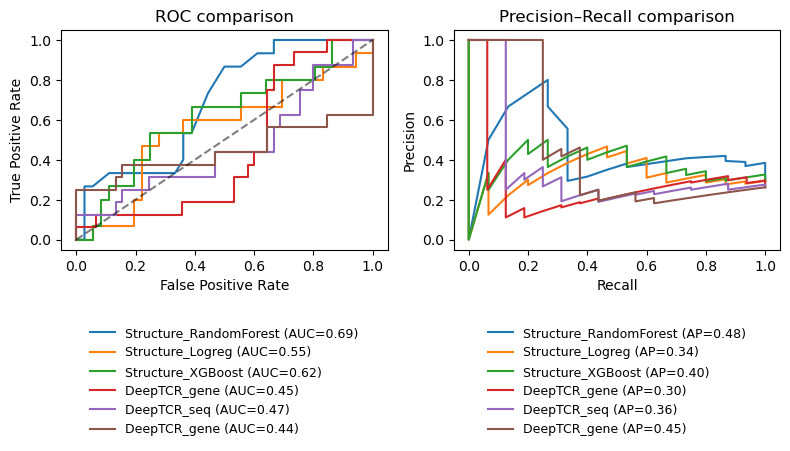

In [60]:
# Create figure and two subplots: ax1 = ROC, ax2 = PR
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 5.5), sharey=False)

def add_plot(true, pred, label):
    precision, recall, _ = precision_recall_curve(true, pred)
    ap = average_precision_score(true, pred)
    fpr, tpr, _ = roc_curve(true, pred)
    roc_auc = auc(fpr, tpr)
    ax1.plot(fpr, tpr, label=f"{label} (AUC={roc_auc:.2f})")
    ax2.plot(recall, precision, label=f"{label} (AP={ap:.2f})")


add_plot(out_rf[1]["y_true"].values, out_rf[1]["y_prob_1"].values, "Structure_RandomForest")   
add_plot(out_lr[1]["y_true"].values, out_lr[1]["y_prob_1"].values, "Structure_Logreg")    
add_plot(out_xgb[1]["y_true"].values, out_xgb[1]["y_prob_1"].values, "Structure_XGBoost")   

add_plot(ss["y_test"], ss["y_pred_1"], "DeepTCR_gene")   
add_plot(ss["y_test"], ss["y_pred_1_only_seq"], "DeepTCR_seq")   
add_plot(ss["y_test"], ss["y_pred_1_only_gene"], "DeepTCR_gene")        

# ROC plot formatting
ax1.plot([0, 1], [0, 1], "k--", alpha=0.5)
ax1.set_xlabel("False Positive Rate")
ax1.set_ylabel("True Positive Rate")
ax1.set_title("ROC comparison")

# PR plot formatting
ax2.set_xlabel("Recall")
ax2.set_ylabel("Precision")
ax2.set_title("Precision–Recall comparison")


ax1.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.3),   # adjust downward
    frameon=False,                 # cleaner look
    fontsize=9, ncol=1
)
ax2.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.3),   # adjust downward
    frameon=False,                 # cleaner look
    fontsize=9, ncol=1
)

plt.tight_layout(rect=[0, 0.05, 1, 1])   # leave space on the right
plt.savefig(out_dir / 'fig1_benchmark_performance.png')

## Fig2. Robustness evaluation

### 2.1 Model stability across random seeds

To assess robustness to random initialization and train/test splits, 

we trained our chosen classifier (XGBoost) on the same feature set using multiple random seeds (e.g. 10 seeds). 

For each seed, we repeated the train/validation split and cross-validation procedure, 

recording the cross-validated AUC and average precision (AP) on the training set and AUC/AP on the held-out test set. 

We summarized model stability by reporting the mean and standard deviation of these metrics across seeds. 

We also confirmed that the ranking of top structural features (from SHAP analysis) remained qualitatively consistent across seeds.

In [69]:
def train_with_shap(df, label_col, base_cfg, model_name="xgboost", seed=13):
    """
    Train model with given seed and return:
    - result dict from train_and_evaluate
    - mean_abs_shap: pandas Series indexed by feature_name
    """
    cfg = deepcopy(base_cfg)
    cfg["random_seed"] = seed

    # Train & eval
    result = train_and_evaluate(df, label_col, cfg, model_name=model_name)
    model: Pipeline = result["model"]

    preproc = model.named_steps.get("preprocess")
    clf = model.named_steps["clf"]

    X_train = result["X_train"]
    X_test = result["X_test"]

    # Transform features for SHAP
    X_train_proc = preproc.transform(X_train) if preproc is not None else X_train
    X_test_proc = preproc.transform(X_test) if preproc is not None else X_test

    feature_info = select_feature_columns(df, label_col)
    feature_names = get_feature_names(preproc, feature_info["categorical"], feature_info["numerical"])

    # Normalize model_name
    name = model_name.lower()

    # --- Compute SHAP values depending on model type ---
    if name in {"xgboost", "random_forest", "gradient_boosting"}:
        explainer = shap.TreeExplainer(clf)
        shap_values = explainer.shap_values(X_test_proc)

    elif name in {"logreg", "logistic_regression"}:
        explainer = shap.LinearExplainer(clf, X_train_proc)
        shap_values = explainer.shap_values(X_test_proc)

    else:
        raise ValueError(f"SHAP not implemented for model_name='{model_name}'")

    shap_vals_array = np.array(shap_values)

    # Case 1: tree models returning [class0, class1]
    if isinstance(shap_values, list) and len(shap_values) > 1:
        shap_vals_array = shap_values[1]  # positive class

    # Case 2: shape (n_samples, n_features, 2) → take class 1
    if shap_vals_array.ndim == 3 and shap_vals_array.shape[-1] == 2:
        shap_vals_array = shap_vals_array[..., 1]

    # Now shap_vals_array should be (n_samples, n_features)
    mean_abs = np.abs(shap_vals_array).mean(axis=0)
    mean_abs_series = pd.Series(mean_abs, index=feature_names).sort_values(ascending=False)

    return result, mean_abs_series

In [68]:
def shap_stability_across_seeds(df, label_col, base_cfg, model_name="xgboost", seeds=range(10), top_n=30):
    """
    For each seed:
      - Train model
      - Compute SHAP mean|value|
      - Store top-N features
    Returns:
      - per_seed_topN: dict seed -> list of feature names
      - per_seed_metrics: DataFrame of performance metrics
      - all_mean_abs: DataFrame of mean_abs_shap per seed
    """
    per_seed_topN = {}
    records = []
    all_mean_abs = []

    for seed in seeds:
        print(f"\n=== Seed {seed} ===")
        result, mean_abs_series = train_with_shap(df, label_col, base_cfg, model_name=model_name, seed=seed)
        m = result["metrics"]
        print(f"Seed {seed}: test AUC={m['test_auc']:.3f}, AP={m['test_ap']:.3f}")

        top_features = mean_abs_series.head(top_n).index.tolist()
        per_seed_topN[seed] = top_features

        records.append({
            "seed": seed,
            "train_cv_auc": m["train_cv_auc"],
            "train_cv_ap": m["train_cv_ap"],
            "test_auc": m["test_auc"],
            "test_ap": m["test_ap"],
        })

        mean_abs_df = mean_abs_series.to_frame(name=f"seed_{seed}")
        all_mean_abs.append(mean_abs_df)

    metrics_df = pd.DataFrame(records)
    all_mean_abs_df = pd.concat(all_mean_abs, axis=1)

    return per_seed_topN, metrics_df, all_mean_abs_df


In [110]:
seeds = range(10)
top_n = int((len(feature_use)-1)*0.3)
print(f"Top {top_n} out of {len(feature_use)-1}")

per_seed_topN_xgb, metrics_df_xgb, mean_abs_all_xgb = shap_stability_across_seeds(
    df_unique[feature_use],
    label_col,
    cfg,
    model_name="xgboost",
    seeds=seeds,
    top_n=top_n,
)
metrics_df_xgb.to_csv(out_dir / "shap_seed_metrics_xgb.csv", index=False)
mean_abs_all_xgb.to_csv(out_dir / "shap_mean_abs_all_seeds_xgb.csv")


per_seed_topN_lr, metrics_df_lr, mean_abs_all_lr = shap_stability_across_seeds(
    df_unique[feature_use],
    label_col,
    cfg,
    model_name="logreg",
    seeds=seeds,
    top_n=top_n,
)
metrics_df_lr.to_csv(out_dir / "shap_seed_metrics_lr.csv", index=False)
mean_abs_all_lr.to_csv(out_dir / "shap_mean_abs_all_seeds_lr.csv")

per_seed_topN_rf, metrics_df_rf, mean_abs_all_rf = shap_stability_across_seeds(
    df_unique[feature_use],
    label_col,
    cfg,
    model_name="random_forest",
    seeds=seeds,
    top_n=top_n,
)
metrics_df_rf.to_csv(out_dir / "shap_seed_metrics_rf.csv", index=False)
mean_abs_all_rf.to_csv(out_dir / "shap_mean_abs_all_seeds_rf.csv")

Top 148 out of 496

=== Seed 0 ===


Seed 0: test AUC=0.589, AP=0.367

=== Seed 1 ===
Seed 1: test AUC=0.624, AP=0.500

=== Seed 2 ===
Seed 2: test AUC=0.744, AP=0.622

=== Seed 3 ===
Seed 3: test AUC=0.693, AP=0.461

=== Seed 4 ===
Seed 4: test AUC=0.639, AP=0.453

=== Seed 5 ===
Seed 5: test AUC=0.617, AP=0.550

=== Seed 6 ===
Seed 6: test AUC=0.654, AP=0.441

=== Seed 7 ===
Seed 7: test AUC=0.578, AP=0.385

=== Seed 8 ===
Seed 8: test AUC=0.537, AP=0.370

=== Seed 9 ===
Seed 9: test AUC=0.694, AP=0.517

=== Seed 0 ===
Seed 0: test AUC=0.670, AP=0.474

=== Seed 1 ===
Seed 1: test AUC=0.757, AP=0.668

=== Seed 2 ===
Seed 2: test AUC=0.593, AP=0.366

=== Seed 3 ===
Seed 3: test AUC=0.637, AP=0.390

=== Seed 4 ===
Seed 4: test AUC=0.500, AP=0.303

=== Seed 5 ===
Seed 5: test AUC=0.456, AP=0.323

=== Seed 6 ===
Seed 6: test AUC=0.589, AP=0.359

=== Seed 7 ===
Seed 7: test AUC=0.541, AP=0.411

=== Seed 8 ===
Seed 8: test AUC=0.419, AP=0.259

=== Seed 9 ===
Seed 9: test AUC=0.572, AP=0.435

=== Seed 0 ===
Seed 0: test AUC=0.5

### 2.2 Structural noise perturbation tests

You ideally perturb coordinates and re-run feature extraction, but that’s heavy. 

A practical approximation is to inject small Gaussian noise into the numeric structural features and see if performance / feature rankings are stable.

To simulate uncertainty in in-silico structural models (e.g. minor coordinate deviations in AlphaFold/TCRBuilder2 predictions), we performed a structural noise perturbation analysis. 

We added small Gaussian noise to all numeric structural features (σ set to 5–10% of each feature’s empirical standard deviation), 

re-ran the training pipeline on the perturbed features, and repeated this 5–10 times. 

We compared AUC/AP across noise realizations and examined whether the most important structural features (from SHAP) remained consistent. 

Stable performance and feature rankings indicate that the model is robust to realistic levels of structural noise.

In [80]:
def add_feature_noise(df, noise_scale=0.1, random_state=None):
    """
    noise_scale: fraction of feature std (e.g. 0.05 = 5% of std).
    """
    rng = check_random_state(random_state)
    df_noisy = df.copy()
    num_cols = df_noisy.select_dtypes(include=["number"]).columns.tolist()
    
    for col in num_cols:
        if col == label_col:
            continue
        col_vals = df_noisy[col].values.astype(float)
        std = np.nanstd(col_vals)
        if std == 0 or np.isnan(std):
            continue
        noise = rng.normal(loc=0.0, scale=noise_scale * std, size=col_vals.shape)
        df_noisy[col] = col_vals + noise
    return df_noisy

def run_noise_robustness(df, label_col, base_cfg, model_name="xgboost", n_runs=5, noise_scale=0.1):
    records = []
    for i in range(n_runs):
        df_noisy = add_feature_noise(df, noise_scale=noise_scale, random_state=100 + i)
        cfg = deepcopy(base_cfg)
        cfg["random_seed"] = 13 + i
        result = train_and_evaluate(df_noisy, label_col, cfg, model_name=model_name)
        m = result["metrics"]
        records.append({
            "run": i,
            "noise_scale": noise_scale,
            "train_cv_auc": m["train_cv_auc"],
            "train_cv_ap": m["train_cv_ap"],
            "test_auc": m["test_auc"],
            "test_ap": m["test_ap"],
        })
        print(f"Noise run {i}: test AUC={m['test_auc']:.3f}, AP={m['test_ap']:.3f}")
    return pd.DataFrame(records)

In [81]:
noise_df_xgb = run_noise_robustness(df_unique[feature_use], label_col, cfg, model_name="xgboost", n_runs=10, noise_scale=0.05)
noise_df_xgb.to_csv(out_dir / "noise_robustness_xgb.csv", index=False)

noise_df_lr = run_noise_robustness(df_unique[feature_use], label_col, cfg, model_name="logreg", n_runs=10, noise_scale=0.05)
noise_df_lr.to_csv(out_dir / "noise_robustness_lr.csv", index=False)

noise_df_rf = run_noise_robustness(df_unique[feature_use], label_col, cfg, model_name="random_forest", n_runs=10, noise_scale=0.05)
noise_df_rf.to_csv(out_dir / "noise_robustness_rf.csv", index=False)

Noise run 0: test AUC=0.596, AP=0.365
Noise run 1: test AUC=0.657, AP=0.446
Noise run 2: test AUC=0.530, AP=0.476
Noise run 3: test AUC=0.617, AP=0.418
Noise run 4: test AUC=0.648, AP=0.498
Noise run 5: test AUC=0.602, AP=0.490
Noise run 6: test AUC=0.667, AP=0.418
Noise run 7: test AUC=0.602, AP=0.409
Noise run 8: test AUC=0.617, AP=0.371
Noise run 9: test AUC=0.583, AP=0.443
Noise run 0: test AUC=0.522, AP=0.330
Noise run 1: test AUC=0.520, AP=0.362
Noise run 2: test AUC=0.631, AP=0.418
Noise run 3: test AUC=0.567, AP=0.373
Noise run 4: test AUC=0.593, AP=0.428
Noise run 5: test AUC=0.578, AP=0.361
Noise run 6: test AUC=0.570, AP=0.339
Noise run 7: test AUC=0.437, AP=0.298
Noise run 8: test AUC=0.630, AP=0.386
Noise run 9: test AUC=0.548, AP=0.360
Noise run 0: test AUC=0.605, AP=0.388
Noise run 1: test AUC=0.606, AP=0.370
Noise run 2: test AUC=0.602, AP=0.417
Noise run 3: test AUC=0.545, AP=0.332
Noise run 4: test AUC=0.692, AP=0.508
Noise run 5: test AUC=0.669, AP=0.506
Noise run 6:

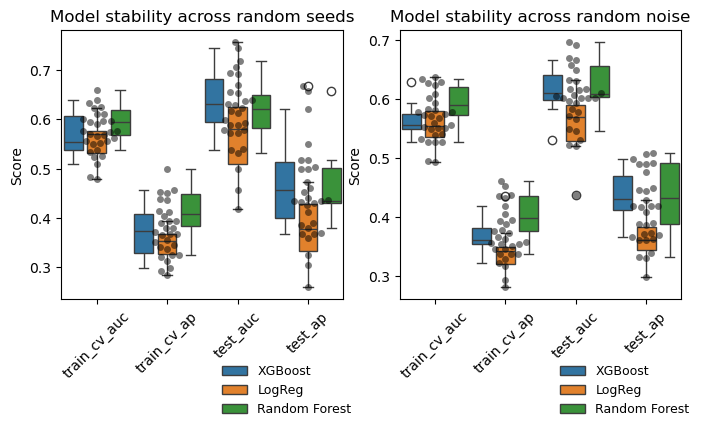

<Figure size 700x500 with 0 Axes>

In [111]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3.5), sharey=False)

plt.figure(figsize=(7,5))
sns.boxplot(
    data=pd.concat([
    metrics_df_xgb.melt(id_vars="seed", value_vars=["train_cv_auc","train_cv_ap", "test_auc","test_ap"], var_name = 'metric', value_name='XGBoost'),
    metrics_df_lr.melt(id_vars="seed", value_vars=["train_cv_auc","train_cv_ap", "test_auc","test_ap"], var_name = 'metric', value_name='LogReg'),
    metrics_df_rf.melt(id_vars="seed", value_vars=["train_cv_auc","train_cv_ap", "test_auc","test_ap"], var_name = 'metric', value_name='Random Forest')]).melt(
        id_vars=["seed","metric"], value_vars=["XGBoost","LogReg","Random Forest"]
    ),
    x="metric", y="value", hue="variable", ax=ax1,width=1, gap=0.2
)
sns.swarmplot(
    data=pd.concat([
    metrics_df_xgb.melt(id_vars="seed", value_vars=["train_cv_auc","train_cv_ap", "test_auc","test_ap"], var_name = 'metric', value_name='XGBoost'),
    metrics_df_lr.melt(id_vars="seed", value_vars=["train_cv_auc","train_cv_ap", "test_auc","test_ap"], var_name = 'metric', value_name='LogReg'),
    metrics_df_rf.melt(id_vars="seed", value_vars=["train_cv_auc","train_cv_ap", "test_auc","test_ap"], var_name = 'metric', value_name='Random Forest')]).melt(
        id_vars=["seed","metric"], value_vars=["XGBoost","LogReg","Random Forest"]
    ),
    x="metric", y="value", color="black", alpha=0.5, ax=ax1
)

sns.boxplot(
    data=pd.concat([
    noise_df_xgb.melt(id_vars="run", value_vars=["train_cv_auc","train_cv_ap", "test_auc","test_ap"], var_name = 'metric', value_name='XGBoost'),
    noise_df_lr.melt(id_vars="run", value_vars=["train_cv_auc","train_cv_ap", "test_auc","test_ap"], var_name = 'metric', value_name='LogReg'),
    noise_df_rf.melt(id_vars="run", value_vars=["train_cv_auc","train_cv_ap", "test_auc","test_ap"], var_name = 'metric', value_name='Random Forest')]).melt(
        id_vars=["run","metric"], value_vars=["XGBoost","LogReg","Random Forest"]
    ),
    x="metric", y="value", hue="variable", ax=ax2, width=1, gap=0.2
)
sns.swarmplot(
    data=pd.concat([
    noise_df_xgb.melt(id_vars="run", value_vars=["train_cv_auc","train_cv_ap", "test_auc","test_ap"], var_name = 'metric', value_name='XGBoost'),
    noise_df_lr.melt(id_vars="run", value_vars=["train_cv_auc","train_cv_ap", "test_auc","test_ap"], var_name = 'metric', value_name='LogReg'),
    noise_df_rf.melt(id_vars="run", value_vars=["train_cv_auc","train_cv_ap", "test_auc","test_ap"], var_name = 'metric', value_name='Random Forest')]).melt(
        id_vars=["run","metric"], value_vars=["XGBoost","LogReg","Random Forest"]
    ),
    x="metric", y="value", color="black", alpha=0.5, ax=ax2
)
ax2.set_ylabel("Score")
ax2.set_xlabel("")
ax2.set_title("Model stability across random noise")
ax2.tick_params(axis='x', rotation=45)

ax1.set_ylabel("Score")
ax1.set_xlabel("")
ax1.set_title("Model stability across random seeds")
ax1.tick_params(axis='x', rotation=45)

ax1.legend(
    loc='upper center',
    bbox_to_anchor=(0.8, -0.2),   # adjust downward
    frameon=False,                 # cleaner look
    fontsize=9, ncol=1
)
ax2.legend(
    loc='upper center',
    bbox_to_anchor=(0.8, -0.2),   # adjust downward
    frameon=False,                 # cleaner look
    fontsize=9, ncol=1
)

plt.tight_layout(rect=[0, 0.05, 1, 1])   # leave space on the right
plt.savefig(out_dir / "fig2_model_stability.png", dpi=300)

### 2.3 Compute Jaccard overlaps of top-N features across seeds

Jaccard index between two sets A and B:

J(A,B) - |A \union B| / |A \cup B|

We can compute a seed × seed Jaccard matrix:

In [103]:
def jaccard(a, b):
    a_set, b_set = set(a), set(b)
    if not a_set and not b_set:
        return 1.0
    return len(a_set & b_set) / len(a_set | b_set)

def compute_jaccard_matrix(per_seed_topN):
    seeds = sorted(per_seed_topN.keys())
    jacc_mat = pd.DataFrame(index=seeds, columns=seeds, dtype=float)
    for i in seeds:
        for j in seeds:
            jacc_mat.loc[i, j] = jaccard(per_seed_topN[i], per_seed_topN[j])
    return jacc_mat


In [112]:
jacc_mat_xgb = compute_jaccard_matrix(per_seed_topN_xgb)
jacc_mat_xgb.to_csv(out_dir / f"shap_top{top_n}_jaccard_xgb.csv")
print(jacc_mat_xgb)
print("Mean pairwise Jaccard:", jacc_mat_xgb.where(~np.eye(len(jacc_mat_xgb), dtype=bool)).mean().mean())

jacc_mat_lr = compute_jaccard_matrix(per_seed_topN_lr)
jacc_mat_lr.to_csv(out_dir / f"shap_top{top_n}_jaccard_lr.csv")
print(jacc_mat_lr)
print("Mean pairwise Jaccard:", jacc_mat_lr.where(~np.eye(len(jacc_mat_lr), dtype=bool)).mean().mean())

jacc_mat_rf = compute_jaccard_matrix(per_seed_topN_rf)
jacc_mat_rf.to_csv(out_dir / f"shap_top{top_n}_jaccard_rf.csv")
print(jacc_mat_rf)
print("Mean pairwise Jaccard:", jacc_mat_rf.where(~np.eye(len(jacc_mat_rf), dtype=bool)).mean().mean())

          0         1         2         3         4         5         6  \
0  1.000000  0.644444  0.644444  0.617486  0.617486  0.644444  0.600000   
1  0.644444  1.000000  0.582888  0.653631  0.617486  0.672316  0.591398   
2  0.644444  0.582888  1.000000  0.662921  0.644444  0.662921  0.608696   
3  0.617486  0.653631  0.662921  1.000000  0.681818  0.701149  0.653631   
4  0.617486  0.617486  0.644444  0.681818  1.000000  0.681818  0.644444   
5  0.644444  0.672316  0.662921  0.701149  0.681818  1.000000  0.662921   
6  0.600000  0.591398  0.608696  0.653631  0.644444  0.662921  1.000000   
7  0.662921  0.608696  0.608696  0.662921  0.653631  0.653631  0.691429   
8  0.644444  0.701149  0.662921  0.644444  0.635359  0.672316  0.617486   
9  0.591398  0.549738  0.653631  0.644444  0.600000  0.608696  0.591398   

          7         8         9  
0  0.662921  0.644444  0.591398  
1  0.608696  0.701149  0.549738  
2  0.608696  0.662921  0.653631  
3  0.662921  0.644444  0.644444  
4  0

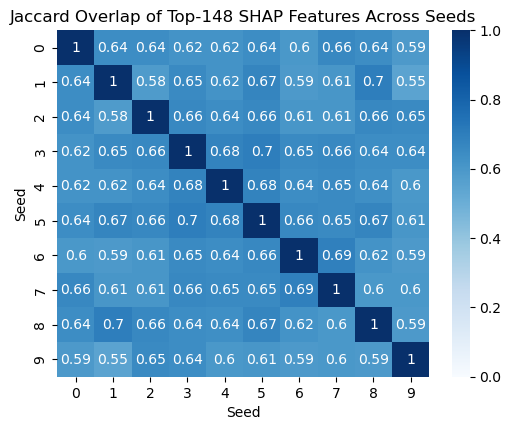

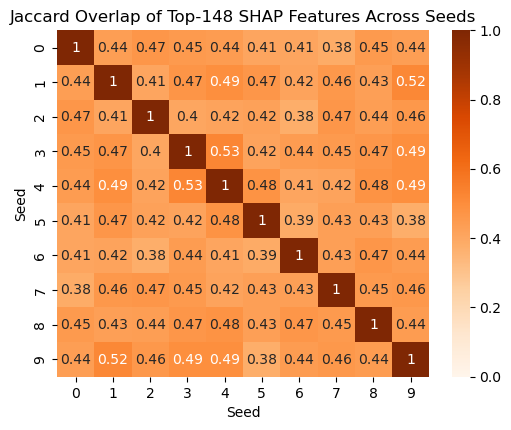

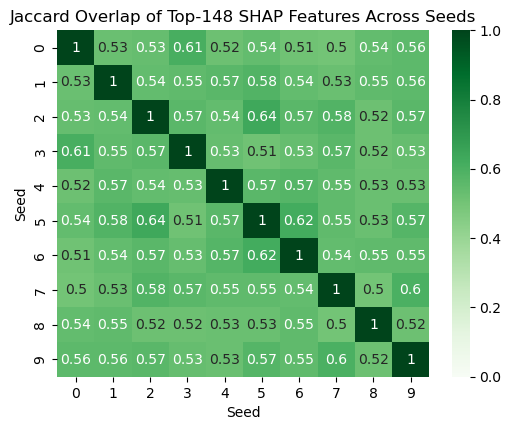

In [243]:
# SHAP Stability Heatmap (Seed × Feature Overlap)
# Pairwise Jaccard similarity between the top 30 SHAP features across 10 random seeds. 
# High similarity (0.65–0.80 range) indicates that the model repeatedly identifies a consistent subset of structural predictors.

plt.figure(figsize=(6,4.5))
sns.heatmap(jacc_mat_xgb, annot=True, cmap="Blues", vmin=0, vmax=1)
plt.title(f"Jaccard Overlap of Top-{top_n} SHAP Features Across Seeds")
plt.xlabel("Seed")
plt.ylabel("Seed")
plt.savefig("/workspaces/tcr_structure_embedding/outputs/maura_unique/reports/fig3_feature_stability_xgb.png", dpi=300)

plt.figure(figsize=(6,4.5))
sns.heatmap(jacc_mat_lr, annot=True, cmap="Oranges", vmin=0, vmax=1)
plt.title(f"Jaccard Overlap of Top-{top_n} SHAP Features Across Seeds")
plt.xlabel("Seed")
plt.ylabel("Seed")
plt.savefig("/workspaces/tcr_structure_embedding/outputs/maura_unique/reports/fig3_feature_stability_lr.png", dpi=300)

plt.figure(figsize=(6,4.5))
sns.heatmap(jacc_mat_rf, annot=True, cmap="Greens", vmin=0, vmax=1)
plt.title(f"Jaccard Overlap of Top-{top_n} SHAP Features Across Seeds")
plt.xlabel("Seed")
plt.ylabel("Seed")
plt.savefig("/workspaces/tcr_structure_embedding/outputs/maura_unique/reports/fig3_feature_stability_rf.png", dpi=300)

In [244]:
from train import select_feature_columns, apply_feature_modifications, build_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

feature_names = select_feature_columns(df_unique[feature_use], label_col)
feature_cols = feature_names["all"]

df_proc = apply_feature_modifications(df_unique[feature_use], cfg)
X = df_proc[feature_cols]

le = LabelEncoder()
y = le.fit_transform(df_proc[label_col])

test_size = cfg.get("test_size", 0.2)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=test_size,
    random_state=0,
    stratify=y,
)

model = build_model("xgboost", feature_names["categorical"], feature_names["numerical"])
model.fit(X_train, y_train)
test_prob = model.predict_proba(X_test)

In [ ]:
explainer = shap.TreeExplainer(model.named_steps["clf"])

/opt/conda/lib/python3.12/site-packages/shap/plots/_beeswarm.py:1033: UserWarning: Not enough data in bin #9 for feature A_cdr3_aa_R, so it'll be ignored. Try increasing the number of records to plot.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/shap/plots/_beeswarm.py:1033: UserWarning: Not enough data in bin #11 for feature A_cdr3_aa_R, so it'll be ignored. Try increasing the number of records to plot.
  warnings.warn(


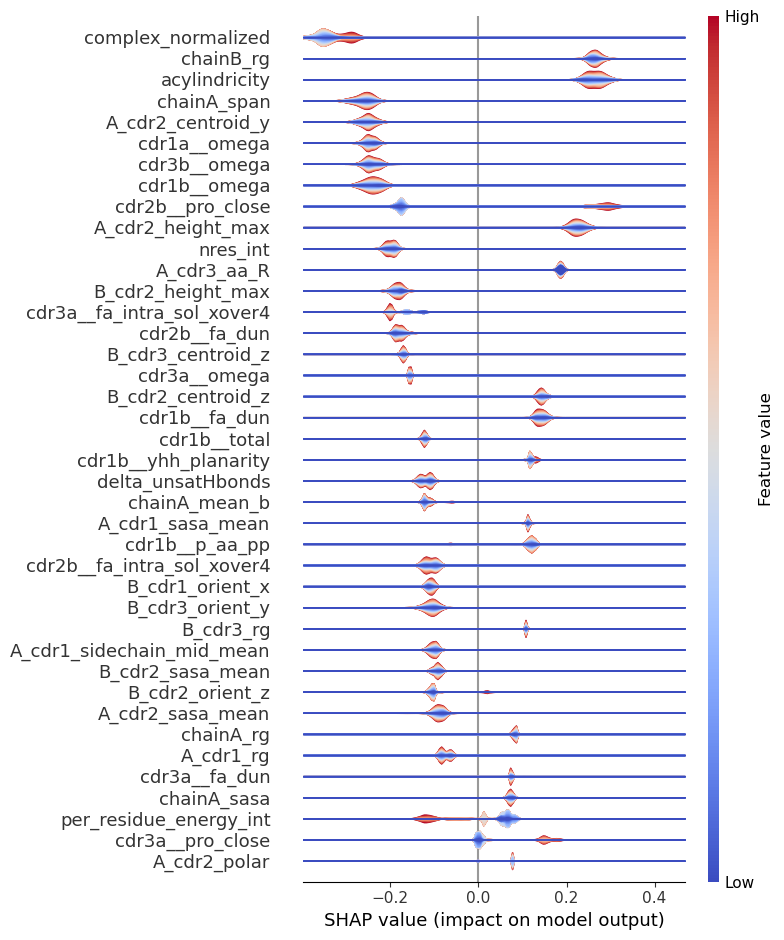

In [247]:
shap.summary_plot(explainer(X), X, plot_type="layered_violin", max_display=40, plot_size=0.2)

# Feature-group ablation studies
You already have “macro” feature groups: struct, inter, res. That’s actually a clean, interpretable ablation. You can formalize it:

To evaluate the relative contribution of different structural feature families, we grouped features into three major categories: (1) global and loop-level structural descriptors (“struct”), (2) interface-level energetics and contact summaries (“inter”), and (3) residue-resolved CDR energy terms (“res”). We trained the model using:

each individual group alone (struct, inter, res),

each pair of groups (struct+inter, struct+res, inter+res),

and the full combination (struct+inter+res).
We compared AUC/AP across these configurations to quantify how much predictive power is lost when each group is removed. This ablation identifies which feature families are most essential for performance and which are partially redundant.

In [ ]:
feature_sets = {
    "global": feature_dict['global_geometry'] + feature_dict['global_shape'],
    "cdr": feature_dict['cdr_geometry'],
    "cdr_composition": feature_dict['cdr_geometry'] + feature_dict['cdr_composition'],
    "cdr_comprehensive" : feature_dict['cdr_geometry'] + feature_dict['cdr_composition'] + feature_dict['cdr_aa_frequency'],
    "global_cdr": feature_dict['global_geometry'] + feature_dict['global_shape'] + feature_dict['cdr_geometry'],
    "global_cdr_composition": feature_dict['global_geometry'] + feature_dict['global_shape'] + feature_dict['cdr_geometry'] + feature_dict['cdr_composition'],
    "global_cdr_comprehensive": feature_dict['global_geometry'] + feature_dict['global_shape'] + feature_dict['cdr_geometry'] + feature_dict['cdr_composition'] + feature_dict['cdr_aa_frequency'],
    "global_composition": feature_dict['global_geometry'] + feature_dict['global_shape'] + feature_dict['cdr_composition'],
    "global_comprehensive": feature_dict['global_geometry'] + feature_dict['global_shape'] + feature_dict['cdr_composition'] + feature_dict['cdr_aa_frequency'],
    "interface": feature_dict['interface_energy'],
    "pairwise": feature_dict['residue_pair_energy'],
    "interface_global": feature_dict['interface_energy'] + feature_dict['global_geometry'] + feature_dict['global_shape'],
    "interface_cdr": feature_dict['interface_energy'] + feature_dict['cdr_geometry'],
    "interface_cdr_composition": feature_dict['interface_energy'] + feature_dict['cdr_geometry'] + feature_dict['cdr_composition'],
    "interface_cdr_comprehensive" : feature_dict['interface_energy'] + feature_dict['cdr_geometry'] + feature_dict['cdr_composition'] + feature_dict['cdr_aa_frequency'],
    "interface_global_cdr": feature_dict['interface_energy'] + feature_dict['global_geometry'] + feature_dict['global_shape'] + feature_dict['cdr_geometry'],
    "interface_global_cdr_composition": feature_dict['interface_energy'] + feature_dict['global_geometry'] + feature_dict['global_shape'] + feature_dict['cdr_geometry'] + feature_dict['cdr_composition'],
    "interface_global_cdr_comprehensive": feature_dict['interface_energy'] + feature_dict['global_geometry'] + feature_dict['global_shape'] + feature_dict['cdr_geometry'] + feature_dict['cdr_composition'] + feature_dict['cdr_aa_frequency'],
    "interface_global_composition": feature_dict['interface_energy'] + feature_dict['global_geometry'] + feature_dict['global_shape'] + feature_dict['cdr_composition'],
    "interface_global_comprehensive": feature_dict['interface_energy'] + feature_dict['global_geometry'] + feature_dict['global_shape'] + feature_dict['cdr_composition'] + feature_dict['cdr_aa_frequency'],
    "pairwise_global": feature_dict['residue_pair_energy'] + feature_dict['global_geometry'] + feature_dict['global_shape'],
    "pairwise_cdr": feature_dict['residue_pair_energy'] + feature_dict['cdr_geometry'],
    "pairwise_cdr_composition": feature_dict['residue_pair_energy'] + feature_dict['cdr_geometry'] + feature_dict['cdr_composition'],
    "pairwise_cdr_comprehensive" : feature_dict['residue_pair_energy'] + feature_dict['cdr_geometry'] + feature_dict['cdr_composition'] + feature_dict['cdr_aa_frequency'],
    "pairwise_global_cdr": feature_dict['residue_pair_energy'] + feature_dict['global_geometry'] + feature_dict['global_shape'] + feature_dict['cdr_geometry'],
    "pairwise_global_cdr_composition": feature_dict['residue_pair_energy'] + feature_dict['global_geometry'] + feature_dict['global_shape'] + feature_dict['cdr_geometry'] + feature_dict['cdr_composition'],
    "pairwise_global_cdr_comprehensive": feature_dict['residue_pair_energy'] + feature_dict['global_geometry'] + feature_dict['global_shape'] + feature_dict['cdr_geometry'] + feature_dict['cdr_composition'] + feature_dict['cdr_aa_frequency'],
    "pairwise_global_composition": feature_dict['residue_pair_energy'] + feature_dict['global_geometry'] + feature_dict['global_shape'] + feature_dict['cdr_composition'],
    "pairwise_global_comprehensive": feature_dict['residue_pair_energy'] + feature_dict['global_geometry'] + feature_dict['global_shape'] + feature_dict['cdr_composition'] + feature_dict['cdr_aa_frequency'],
}

def run_feature_group_ablation(df_all, feature_sets, base_cfg, label_col, model_name="xgboost"):
    """
    df_all: merged DataFrame containing all features from struct/inter/res,
            plus 'tcr_id' and label_col.
    feature_sets: dict[str, list[str]] mapping feature-set name -> list of column names
    """
    rows = []

    for fs_name, cols in feature_sets.items():
        # ensure we don't accidentally request missing columns
        missing = [c for c in cols if c not in df_all.columns]
        if missing:
            print(f"[WARN] feature set '{fs_name}' missing {len(missing)} columns, skipping those.")
            cols = [c for c in cols if c in df_all.columns]

        # always keep tcr_id + label
        keep_cols = [id_col, label_col] + cols
        keep_cols = [c for c in keep_cols if c in df_all.columns]

        df_fs = df_all[keep_cols].copy()
        df_fs = df_fs.loc[~df_fs[label_col].isna()]

        print(f"[{fs_name}] {df_fs.shape[0]} samples, {df_fs.shape[1]} columns (features: {len(cols)})")

        cfg = deepcopy(base_cfg)
        result = bjob(df_fs, label_col, cfg, model_name=model_name)
        m = result["metrics"]

        rows.append({
            "feature_set": fs_name,
            "n_features": len(cols),
            "train_cv_auc": m["train_cv_auc"],
            "train_cv_ap": m["train_cv_ap"],
            "test_auc": m["test_auc"],
            "test_ap": m["test_ap"],
        })

    return pd.DataFrame(rows)


In [ ]:
# df_all is your merged struct+inter+res table, with label already added
ablation_df_xgb = run_feature_group_ablation(
    df_all=df_unique,
    feature_sets=feature_sets,
    base_cfg=cfg,
    label_col=label_col,
    model_name="xgboost",
)
ablation_df_xgb.to_csv("/workspaces/tcr_structure_embedding/outputs/maura_unique/reports/feature_group_ablation_xgb.csv",index=False,)


ablation_df_lr = run_feature_group_ablation(
    df_all=df_unique,
    feature_sets=feature_sets,
    base_cfg=cfg,
    label_col=label_col,
    model_name="logreg",
)
ablation_df_lr.to_csv("/workspaces/tcr_structure_embedding/outputs/maura_unique/reports/feature_group_ablation_lr.csv",index=False,)


ablation_df_rf = run_feature_group_ablation(
    df_all=df_unique,
    feature_sets=feature_sets,
    base_cfg=cfg,
    label_col=label_col,
    model_name="random_forest",
)
ablation_df_rf.to_csv("/workspaces/tcr_structure_embedding/outputs/maura_unique/reports/feature_group_ablation_rf.csv",index=False,)


[global] 253 samples, 22 columns (features: 21)
[cdr] 253 samples, 91 columns (features: 90)
[cdr_composition] 253 samples, 115 columns (features: 114)
[cdr_comprehensive] 253 samples, 235 columns (features: 234)
[global_cdr] 253 samples, 112 columns (features: 111)
[global_cdr_composition] 253 samples, 136 columns (features: 135)
[global_cdr_comprehensive] 253 samples, 256 columns (features: 255)
[global_composition] 253 samples, 46 columns (features: 45)
[global_comprehensive] 253 samples, 166 columns (features: 165)
[interface] 253 samples, 22 columns (features: 21)
[pairwise] 253 samples, 221 columns (features: 220)
[interface_global] 253 samples, 43 columns (features: 42)
[interface_cdr] 253 samples, 112 columns (features: 111)
[interface_cdr_composition] 253 samples, 136 columns (features: 135)
[interface_cdr_comprehensive] 253 samples, 256 columns (features: 255)
[interface_global_cdr] 253 samples, 133 columns (features: 132)
[interface_global_cdr_composition] 253 samples, 157 c

/tmp/ipykernel_32151/1802216591.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha="right")
/tmp/ipykernel_32151/1802216591.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha="right")
/tmp/ipykernel_32151/1802216591.py:80: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha="right")


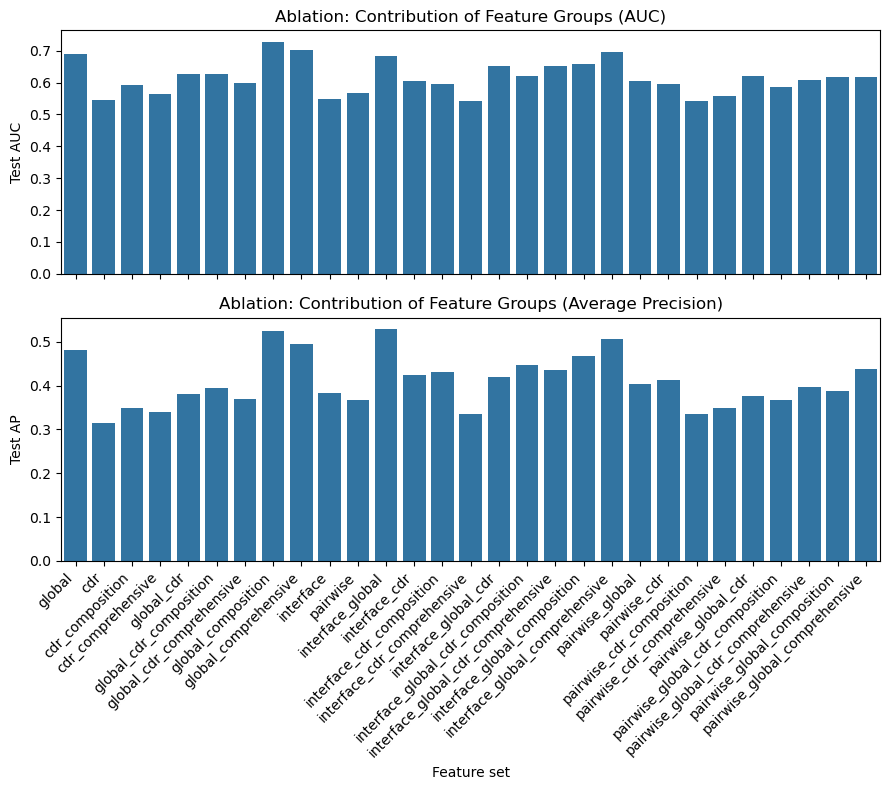

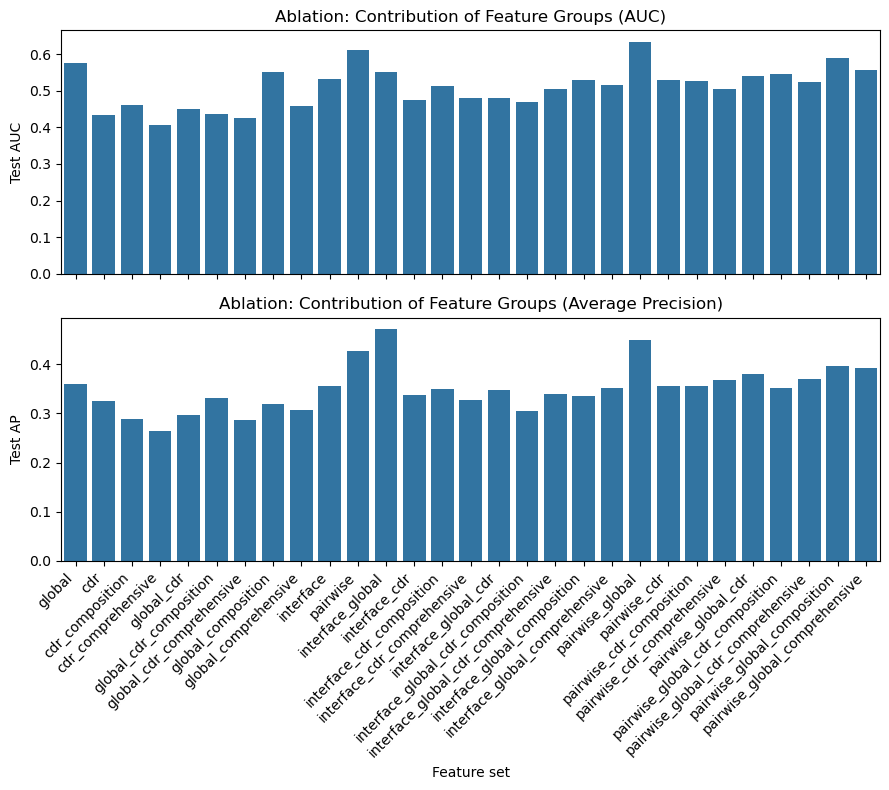

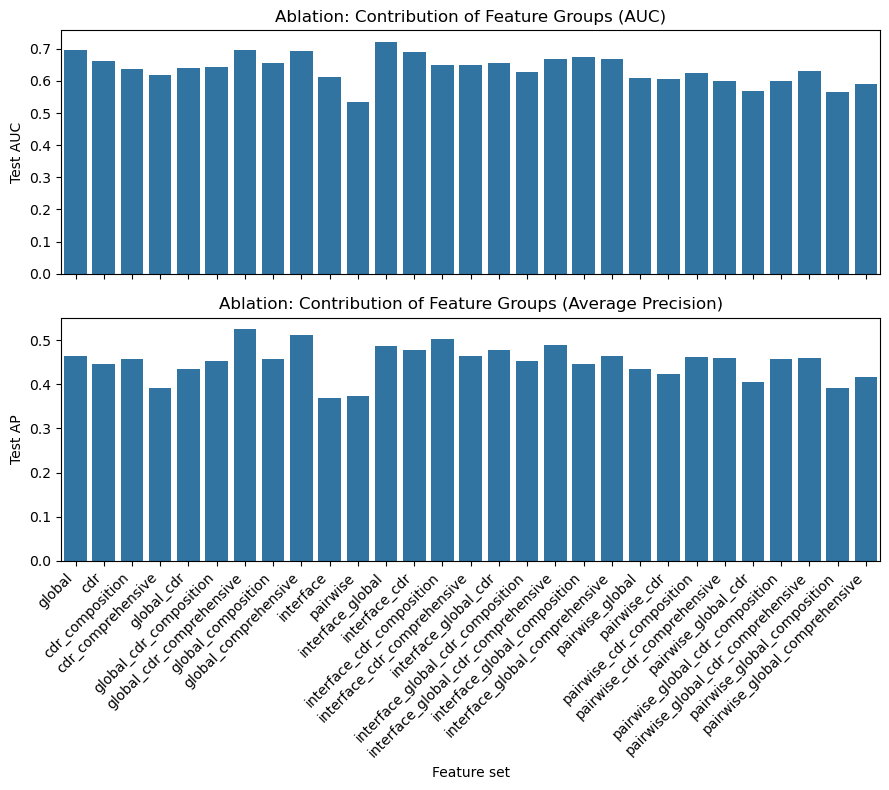

In [ ]:
# Ablation Study: Feature Group Importance
# Show impact of removing each feature group on performance.
# Removing any of the three major structural groups 
# (global geometry, interface properties, residue-level energies) reduces AUC, 
# confirming that each provides complementary information.

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 8), sharex=True)
sns.barplot(
    data=ablation_df_xgb,
    x="feature_set",
    y="test_auc",
    ax=ax1
)
ax1.set_ylabel("Test AUC")
# ax1.set_ylim(0.9, 1.0)
ax1.set_title("Ablation: Contribution of Feature Groups (AUC)")

sns.barplot(
    data=ablation_df_xgb,
    x="feature_set",
    y="test_ap",
    ax=ax2
)
ax2.set_ylabel("Test AP")
# ax2.set_ylim(0.9, 1.0)
ax2.set_xlabel("Feature set")
ax2.set_title("Ablation: Contribution of Feature Groups (Average Precision)")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.savefig("/workspaces/tcr_structure_embedding/outputs/maura_unique/reports/fig_feature_group_ablation_xgb.png", dpi=300)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 8), sharex=True)
sns.barplot(
    data=ablation_df_lr,
    x="feature_set",
    y="test_auc",
    ax=ax1
)
ax1.set_ylabel("Test AUC")
# ax1.set_ylim(0.9, 1.0)
ax1.set_title("Ablation: Contribution of Feature Groups (AUC)")

sns.barplot(
    data=ablation_df_lr,
    x="feature_set",
    y="test_ap",
    ax=ax2
)
ax2.set_ylabel("Test AP")
# ax2.set_ylim(0.9, 1.0)
ax2.set_xlabel("Feature set")
ax2.set_title("Ablation: Contribution of Feature Groups (Average Precision)")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.savefig("/workspaces/tcr_structure_embedding/outputs/maura_unique/reports/fig_feature_group_ablation_lr.png", dpi=300)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 8), sharex=True)
sns.barplot(
    data=ablation_df_rf,
    x="feature_set",
    y="test_auc",
    ax=ax1
)
ax1.set_ylabel("Test AUC")
# ax1.set_ylim(0.9, 1.0)
ax1.set_title("Ablation: Contribution of Feature Groups (AUC)")

sns.barplot(
    data=ablation_df_rf,
    x="feature_set",
    y="test_ap",
    ax=ax2
)
ax2.set_ylabel("Test AP")
# ax2.set_ylim(0.9, 1.0)
ax2.set_xlabel("Feature set")
ax2.set_title("Ablation: Contribution of Feature Groups (Average Precision)")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.savefig("/workspaces/tcr_structure_embedding/outputs/maura_unique/reports/fig_feature_group_ablation_rf.png", dpi=300)


# Leave-one-family-out validation

To test whether the model generalizes beyond specific TCR clonotypes or sequence families, we performed leave-one-family-out validation. 

Using a family identifier (e.g. clonotype or sequence cluster) from the metadata, 

we iteratively held out all TCRs belonging to a single family as the test set while training the model on all remaining families. 

For each held-out family, we evaluated AUC/AP on that family’s TCRs. 

This procedure prevents sequence-similar TCRs from leaking between train and test sets and measures how well structural features generalize to unseen TCR families.

In [ ]:
from sklearn.preprocessing import LabelEncoder

def leave_one_family_out(df, label_col, family_col, base_cfg, model_name="xgboost"):
    """
    df must already contain label_col and family_col.
    """
    families = df[family_col].dropna().unique().tolist()
    results = []
    for fam in families:
        df_train = df[df[family_col] != fam]
        df_test  = df[df[family_col] == fam]

        # skip tiny families
        if df_test[label_col].nunique() < 2:
            print(f"Skipping family {fam}: only one class present in test.")
            continue
        if df_train[label_col].nunique() < 2:
            print(f"Skipping family {fam}: only one class in train.")
            continue

        # We reuse train_and_evaluate logic but with explicit train/test split:
        # easiest is to hack: temporarily override train_test_split by manually splitting,
        # but simplest for now: do a custom mini-training just for LOO:

        from train import build_model, apply_feature_modifications, select_feature_columns
        from sklearn.metrics import roc_auc_score, average_precision_score

        df_train_proc = apply_feature_modifications(df_train, base_cfg)
        df_test_proc  = apply_feature_modifications(df_test, base_cfg)

        cols = select_feature_columns(df_train_proc, label_col)
        X_train = df_train_proc[cols["all"]]
        X_test  = df_test_proc[cols["all"]]
        # y_train = df_train_proc[label_col].values
        # y_test  = df_test_proc[label_col].values
        
        le = LabelEncoder()
        y_train = le.fit_transform(df_train_proc[label_col].values)
        y_test = le.fit_transform(df_test_proc[label_col].values)


        model = build_model(model_name, cols["categorical"], cols["numerical"])
        model.fit(X_train, y_train)
        y_prob = model.predict_proba(X_test)[:, 1]

        auc = roc_auc_score(y_test, y_prob)
        ap  = average_precision_score(y_test, y_prob)

        print(f"Family {fam}: AUC={auc:.3f}, AP={ap:.3f}, n_test={len(y_test)}")
        results.append({"family": fam, "n_test": len(y_test), "auc": auc, "ap": ap})

    return pd.DataFrame(results)

In [ ]:

# Paths & config
cfg = load_config(Path("/workspaces/tcr_structure_embedding/pipelines/maura_hnncc/config.yaml"))

# Pre-load feature tables
meta_path    = "/workspaces/tcr_structure_embedding/outputs/maura_hnncc/features/maura_hnncc_metadata.csv"
struct_path = "/workspaces/tcr_structure_embedding/outputs/maura_hnncc/features/maura_hnncc_struct_features.csv"
inter_path  = "/workspaces/tcr_structure_embedding/outputs/maura_hnncc/features/maura_hnncc_interface_analyzer.csv"
res_path    = "/workspaces/tcr_structure_embedding/outputs/maura_hnncc/features/maura_hnncc_residue_energy_cdr.csv"

df_meta = pd.read_csv(struct_path)
df_struct = pd.read_csv(struct_path)
df_inter  = pd.read_csv(inter_path)
df_res    = pd.read_csv(res_path)

# Main combined feature set: struct + inter + res
df_all = _merge_on_id(cfg, [df_meta, df_struct, df_inter, df_res])
df_unique = df_all[df_all['tcr_id'].isin(unique_tcrs['tcr_id'])]
# df_all = add_label_from_metadata(df_all, cfg)

id_col = cfg["id_column"]
label_col = cfg["label_column"]
family_col = "Nils.cdr3b_aa.patient_id.stimulation_0307"  # <-- replace with your actual metadata column

meta_path = Path(cfg["metadata_csv"])
if not meta_path.exists():
    raise FileNotFoundError(f"Metadata CSV not found: {meta_path}")

meta = pd.read_csv(meta_path, encoding=cfg.get("metadata_encoding", "utf-8"))
meta[id_col] = meta[id_col].astype(str).str.replace(".pdb", "", regex=False)

if family_col not in meta.columns:
    raise ValueError(f"family_column '{family_col}' not found in metadata.")
if label_col not in meta.columns:
    raise ValueError(f"label_column '{label_col}' not found in metadata.")

df_all_family = df_unique.merge(meta[[id_col, family_col, label_col]], how="left", left_on=id_col, right_on=id_col)
df_all_family = df_all_family.drop(columns=[id_col])
df_all_family = df_all_family.loc[~df_all_family[label_col].isna()]

df_all_family[[family_col]] = df_all_family[[family_col]].fillna(value="unknown")

loo_df_xgb = leave_one_family_out(df_all_family, label_col, family_col, cfg, model_name="xgboost")
loo_df_xgb.to_csv("/workspaces/tcr_structure_embedding/outputs/maura_unique/reports/leave_one_proteingroup_out_xgb.csv", index=False)

loo_df_lr = leave_one_family_out(df_all_family, label_col, family_col, cfg, model_name="logreg")
loo_df_lr.to_csv("/workspaces/tcr_structure_embedding/outputs/maura_unique/reports/leave_one_proteingroup_out_lr.csv", index=False)

loo_df_rf = leave_one_family_out(df_all_family, label_col, family_col, cfg, model_name="random_forest")
loo_df_rf.to_csv("/workspaces/tcr_structure_embedding/outputs/maura_unique/reports/leave_one_proteingroup_out_rf.csv", index=False)



Family HPV16_E2: AUC=0.390, AP=0.239, n_test=62
Skipping family HPV16_E4: only one class present in test.
Family unknown: AUC=0.700, AP=0.903, n_test=7
Family HPV16_E6: AUC=0.505, AP=0.423, n_test=41
Family HPV16_E1: AUC=0.474, AP=0.339, n_test=44
Family HPV16_E7: AUC=0.314, AP=0.135, n_test=56
Family HPV16_E5: AUC=0.346, AP=0.547, n_test=21
Skipping family HPV16_L1: only one class present in test.
Family HPV16_L2: AUC=1.000, AP=1.000, n_test=2
Family HPV16_E2: AUC=0.374, AP=0.237, n_test=62
Skipping family HPV16_E4: only one class present in test.
Family unknown: AUC=0.800, AP=0.943, n_test=7
Family HPV16_E6: AUC=0.328, AP=0.314, n_test=41
Family HPV16_E1: AUC=0.546, AP=0.437, n_test=44
Family HPV16_E7: AUC=0.307, AP=0.167, n_test=56
Family HPV16_E5: AUC=0.375, AP=0.612, n_test=21
Skipping family HPV16_L1: only one class present in test.
Family HPV16_L2: AUC=1.000, AP=1.000, n_test=2
Family HPV16_E2: AUC=0.416, AP=0.249, n_test=62
Skipping family HPV16_E4: only one class present in te

/tmp/ipykernel_32151/2956310355.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha="right")
/tmp/ipykernel_32151/2956310355.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha="right")
/tmp/ipykernel_32151/2956310355.py:91: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha="right")


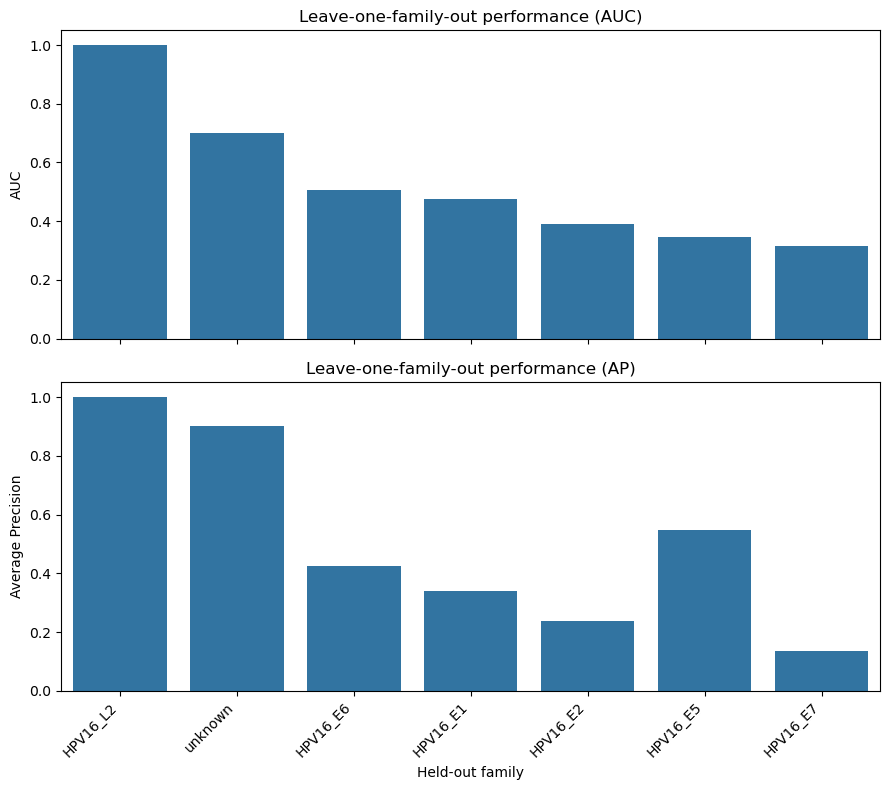

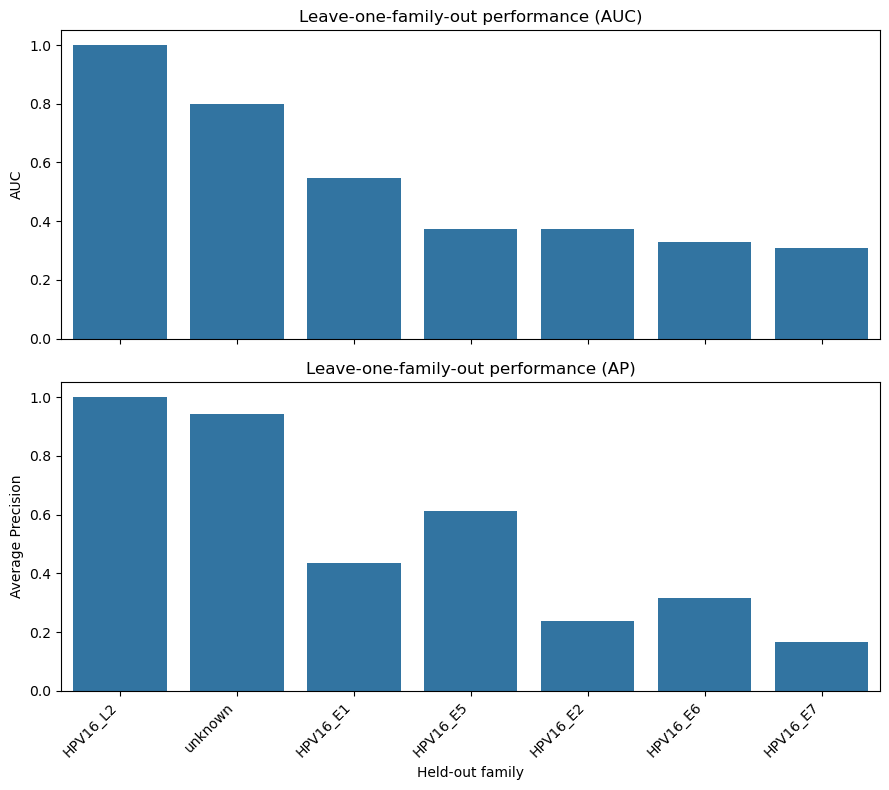

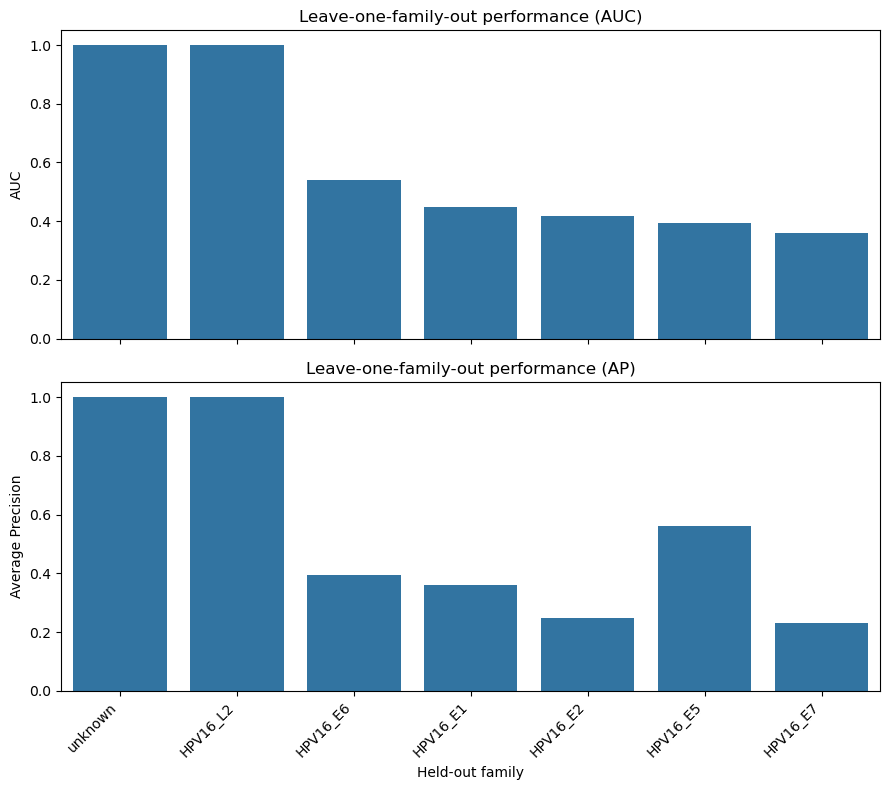

In [ ]:
loo_df_xgb = loo_df_xgb.sort_values("auc", ascending=False)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 8), sharex=True)

# AUC by family
sns.barplot(
    data=loo_df_xgb,
    x="family",
    y="auc",
    ax=ax1,
)
ax1.set_ylabel("AUC")
ax1.set_title("Leave-one-family-out performance (AUC)")

# AP by family
sns.barplot(
    data=loo_df_xgb,
    x="family",
    y="ap",
    ax=ax2,
)
ax2.set_ylabel("Average Precision")
ax2.set_xlabel("Held-out family")
ax2.set_title("Leave-one-family-out performance (AP)")

# Rotate x labels
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.savefig("/workspaces/tcr_structure_embedding/outputs/maura_unique/reports/fig_leave_one_family_out_xgb.png", dpi=300)


loo_df_lr = loo_df_lr.sort_values("auc", ascending=False)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 8), sharex=True)

# AUC by family
sns.barplot(
    data=loo_df_lr,
    x="family",
    y="auc",
    ax=ax1,
)
ax1.set_ylabel("AUC")
ax1.set_title("Leave-one-family-out performance (AUC)")

# AP by family
sns.barplot(
    data=loo_df_lr,
    x="family",
    y="ap",
    ax=ax2,
)
ax2.set_ylabel("Average Precision")
ax2.set_xlabel("Held-out family")
ax2.set_title("Leave-one-family-out performance (AP)")

# Rotate x labels
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.savefig("/workspaces/tcr_structure_embedding/outputs/maura_unique/reports/fig_leave_one_family_out_lr.png", dpi=300)


loo_df_rf = loo_df_rf.sort_values("auc", ascending=False)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 8), sharex=True)

# AUC by family
sns.barplot(
    data=loo_df_rf,
    x="family",
    y="auc",
    ax=ax1,
)
ax1.set_ylabel("AUC")
ax1.set_title("Leave-one-family-out performance (AUC)")

# AP by family
sns.barplot(
    data=loo_df_rf,
    x="family",
    y="ap",
    ax=ax2,
)
ax2.set_ylabel("Average Precision")
ax2.set_xlabel("Held-out family")
ax2.set_title("Leave-one-family-out performance (AP)")

# Rotate x labels
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.savefig("/workspaces/tcr_structure_embedding/outputs/maura_unique/reports/fig_leave_one_family_out_rf.png", dpi=300)


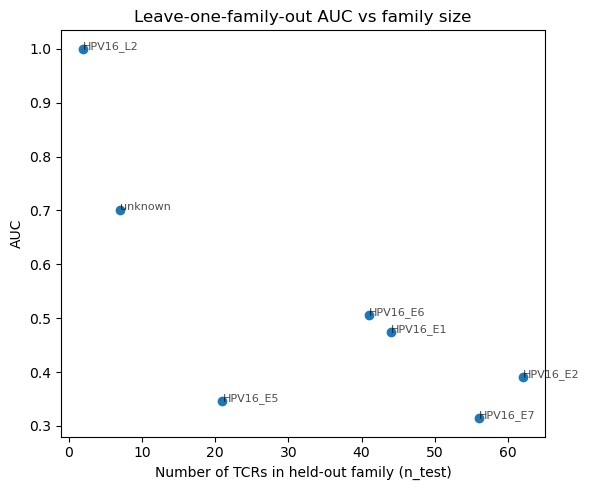

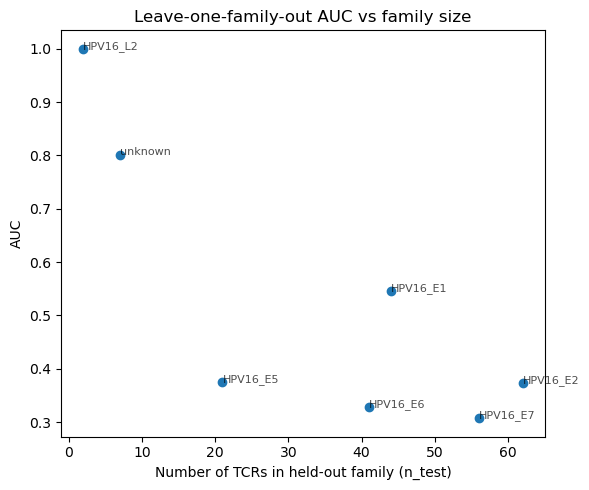

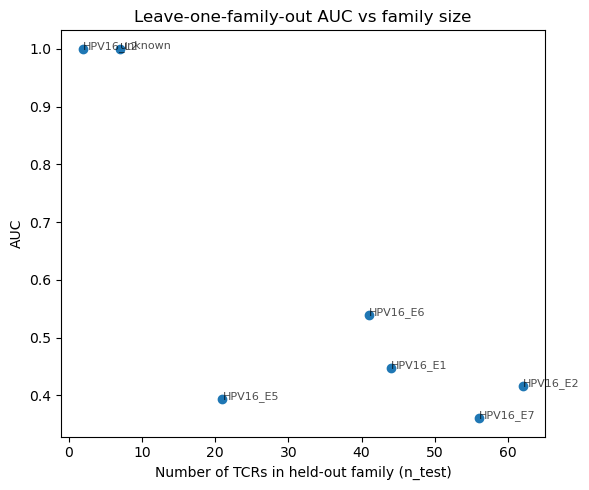

In [ ]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.scatter(loo_df_xgb["n_test"], loo_df_xgb["auc"])
for _, row in loo_df_xgb.iterrows():
    ax.text(row["n_test"], row["auc"], str(row["family"]), fontsize=8, alpha=0.7)

ax.set_xlabel("Number of TCRs in held-out family (n_test)")
ax.set_ylabel("AUC")
ax.set_title("Leave-one-family-out AUC vs family size")
plt.tight_layout()
plt.savefig("/workspaces/tcr_structure_embedding/outputs/maura_unique/reports/fig_loo_family_size_vs_auc_xgb.png", dpi=300)


fig, ax = plt.subplots(figsize=(6, 5))
ax.scatter(loo_df_lr["n_test"], loo_df_lr["auc"])
for _, row in loo_df_lr.iterrows():
    ax.text(row["n_test"], row["auc"], str(row["family"]), fontsize=8, alpha=0.7)

ax.set_xlabel("Number of TCRs in held-out family (n_test)")
ax.set_ylabel("AUC")
ax.set_title("Leave-one-family-out AUC vs family size")
plt.tight_layout()
plt.savefig("/workspaces/tcr_structure_embedding/outputs/maura_unique/reports/fig_loo_family_size_vs_auc_lr.png", dpi=300)


fig, ax = plt.subplots(figsize=(6, 5))
ax.scatter(loo_df_rf["n_test"], loo_df_rf["auc"])
for _, row in loo_df_rf.iterrows():
    ax.text(row["n_test"], row["auc"], str(row["family"]), fontsize=8, alpha=0.7)

ax.set_xlabel("Number of TCRs in held-out family (n_test)")
ax.set_ylabel("AUC")
ax.set_title("Leave-one-family-out AUC vs family size")
plt.tight_layout()
plt.savefig("/workspaces/tcr_structure_embedding/outputs/maura_unique/reports/fig_loo_family_size_vs_auc_rf.png", dpi=300)

# include metadata

In [73]:
# Pre-load feature tables
struct_path = "/workspaces/tcr_structure_embedding/outputs/maura_hnncc/features/maura_hnncc_struct_features.csv"
inter_path  = "/workspaces/tcr_structure_embedding/outputs/maura_hnncc/features/maura_hnncc_interface_analyzer.csv"
res_path    = "/workspaces/tcr_structure_embedding/outputs/maura_hnncc/features/maura_hnncc_residue_energy_cdr.csv"
meta_path   = "/workspaces/tcr_structure_embedding/outputs/maura_hnncc/features/maura_hnncc_metadata.csv"

df_struct = pd.read_csv(struct_path)
df_inter  = pd.read_csv(inter_path)
df_res    = pd.read_csv(res_path)
df_meta   = pd.read_csv(meta_path)

# Main combined feature set: struct + inter + res
df = _merge_on_id(cfg, [df_struct, df_inter, df_res, df_meta])
df2 = df.copy()

dat = pd.read_csv('/workspaces/tcr_structure_embedding/data/maura_hnncc/meta_label_sep4_hpv_specific_with_wholevdj.csv', encoding='latin1')
dat = dat.loc[~dat["TCRBuilder2_log"].astype(str).str.contains("failed", na=False)]

for key, group in dat.groupby(["WholeVdj_A", "WholeVdj_B", label_col])["tcr_id"]:
    tcr_ids = group.tolist()

    # representative TCR for this clone+label
    rep_id = tcr_ids[0]

    # get that row as a 1D Series
    head = df.loc[df["tcr_id"] == rep_id].iloc[0]

    # overwrite every member's row in df2 with this representative feature vector
    for tcr in tcr_ids:
        # keep tcr_id column as the actual tcr
        row = head.copy()
        row["tcr_id"] = tcr
        df2.loc[df2["tcr_id"] == tcr, :] = row.values

df2 = add_label_from_metadata(df2, cfg)
df2 = df2.loc[~df2[label_col].isna()]


feature_dict['metadata'] = [
    'orig.ident',
    'Age',
    'Gender',
    'chemistry',
    'Timepoint',
    'TissueSite',
    'meta.ID',
    'peptide'
]

save_dir = Path('/workspaces/tcr_structure_embedding/outputs/maura_withsampleinfo/reports/')
save_dir.mkdir(parents=True, exist_ok=True)

In [74]:
seeds = range(10)
feature = feature_dict['global_geometry'] + feature_dict['global_shape'] + feature_dict['cdr_geometry'] + feature_dict['metadata']

top_n = int((len(feature)-1)*0.4)

df_all = df2[feature + [label_col]]
print(df_all.shape)

per_seed_topN_xgb, metrics_df_xgb, mean_abs_all_xgb = shap_stability_across_seeds(
    df_all,
    label_col,
    cfg,
    model_name="xgboost",
    seeds=seeds,
    top_n=top_n,
)

metrics_df_xgb.to_csv(save_dir / "shap_seed_metrics_xgb.csv", index=False)
mean_abs_all_xgb.to_csv(save_dir / "shap_mean_abs_all_seeds_xgb.csv")


per_seed_topN_lr, metrics_df_lr, mean_abs_all_lr = shap_stability_across_seeds(
    df_all,
    label_col,
    cfg,
    model_name="logreg",
    seeds=seeds,
    top_n=top_n,
)

metrics_df_lr.to_csv(save_dir / "shap_seed_metrics_lr.csv", index=False)
mean_abs_all_lr.to_csv(save_dir / "shap_mean_abs_all_seeds_lr.csv")


per_seed_topN_rf, metrics_df_rf, mean_abs_all_rf = shap_stability_across_seeds(
    df_all,
    label_col,
    cfg,
    model_name="random_forest",
    seeds=seeds,
    top_n=top_n,
)

metrics_df_rf.to_csv(save_dir / "shap_seed_metrics_rf.csv", index=False)
mean_abs_all_rf.to_csv(save_dir / "shap_seed_metrics_rf.csv", index=False)

(1500, 120)

=== Seed 0 ===
Seed 0: test AUC=0.996, AP=0.984

=== Seed 1 ===
Seed 1: test AUC=0.995, AP=0.981

=== Seed 2 ===
Seed 2: test AUC=0.996, AP=0.985

=== Seed 3 ===
Seed 3: test AUC=0.991, AP=0.970

=== Seed 4 ===
Seed 4: test AUC=0.997, AP=0.988

=== Seed 5 ===
Seed 5: test AUC=0.997, AP=0.991

=== Seed 6 ===
Seed 6: test AUC=0.997, AP=0.990

=== Seed 7 ===
Seed 7: test AUC=0.987, AP=0.966

=== Seed 8 ===
Seed 8: test AUC=0.996, AP=0.985

=== Seed 9 ===
Seed 9: test AUC=0.991, AP=0.982

=== Seed 0 ===
Seed 0: test AUC=0.959, AP=0.867

=== Seed 1 ===
Seed 1: test AUC=0.957, AP=0.800

=== Seed 2 ===
Seed 2: test AUC=0.969, AP=0.851

=== Seed 3 ===
Seed 3: test AUC=0.955, AP=0.759

=== Seed 4 ===
Seed 4: test AUC=0.965, AP=0.873

=== Seed 5 ===
Seed 5: test AUC=0.971, AP=0.944

=== Seed 6 ===
Seed 6: test AUC=0.970, AP=0.917

=== Seed 7 ===
Seed 7: test AUC=0.939, AP=0.878

=== Seed 8 ===
Seed 8: test AUC=0.972, AP=0.874

=== Seed 9 ===
Seed 9: test AUC=0.956, AP=0.860

=== See

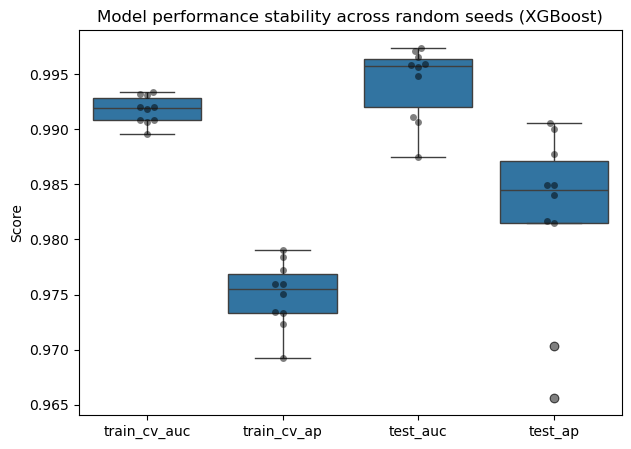

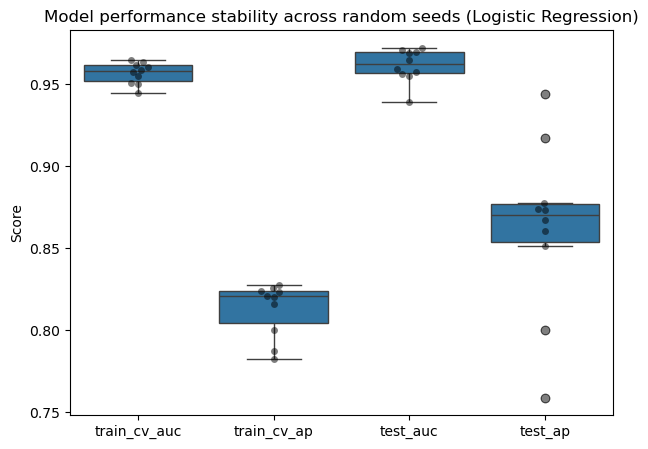

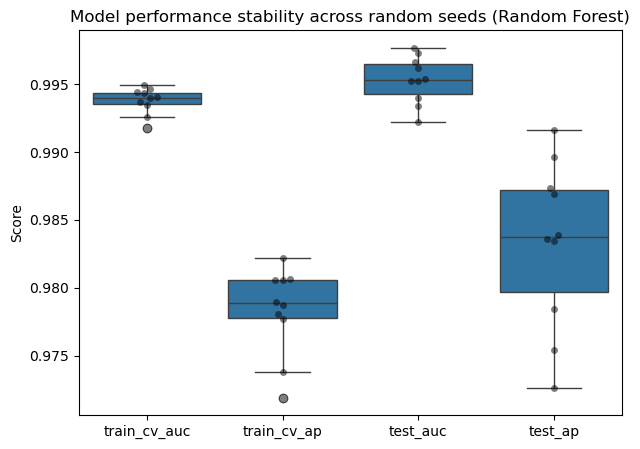

In [75]:
# Model Stability Across Random Seeds
# Stability of classification performance across 10 random seeds. 
# AUC and average precision (AP) show low variance across seeds, 
# demonstrating that model performance is not sensitive to random initialization.

plt.figure(figsize=(7,5))
sns.boxplot(
    data=metrics_df_xgb.melt(id_vars="seed", value_vars=["train_cv_auc","train_cv_ap", "test_auc","test_ap"]),
    x="variable", y="value"
)
sns.swarmplot(
    data=metrics_df_xgb.melt(id_vars="seed", value_vars=["train_cv_auc","train_cv_ap", "test_auc","test_ap"]),
    x="variable", y="value", color="black", alpha=0.5
)
plt.ylabel("Score")
plt.xlabel("")
plt.title("Model performance stability across random seeds (XGBoost)")
plt.savefig(save_dir / "fig_seed_stability_xgb.png", dpi=300)



plt.figure(figsize=(7,5))
sns.boxplot(
    data=metrics_df_lr.melt(id_vars="seed", value_vars=["train_cv_auc","train_cv_ap", "test_auc","test_ap"]),
    x="variable", y="value"
)
sns.swarmplot(
    data=metrics_df_lr.melt(id_vars="seed", value_vars=["train_cv_auc","train_cv_ap", "test_auc","test_ap"]),
    x="variable", y="value", color="black", alpha=0.5
)
plt.ylabel("Score")
plt.xlabel("")
plt.title("Model performance stability across random seeds (Logistic Regression)")
plt.savefig(save_dir / "fig_seed_stability_lr.png", dpi=300)


plt.figure(figsize=(7,5))
sns.boxplot(
    data=metrics_df_rf.melt(id_vars="seed", value_vars=["train_cv_auc","train_cv_ap", "test_auc","test_ap"]),
    x="variable", y="value"
)
sns.swarmplot(
    data=metrics_df_rf.melt(id_vars="seed", value_vars=["train_cv_auc","train_cv_ap", "test_auc","test_ap"]),
    x="variable", y="value", color="black", alpha=0.5
)
plt.ylabel("Score")
plt.xlabel("")
plt.title("Model performance stability across random seeds (Random Forest)")
plt.savefig(save_dir / "fig_seed_stability_rf.png", dpi=300)

In [76]:
jacc_mat_xgb = compute_jaccard_matrix(per_seed_topN_xgb)
jacc_mat_xgb.to_csv(save_dir / f"shap_top{top_n}_jaccard_xgb.csv")
print(jacc_mat_xgb)
print("Mean pairwise Jaccard:", jacc_mat_xgb.where(~np.eye(len(jacc_mat_xgb), dtype=bool)).mean().mean())

jacc_mat_lr = compute_jaccard_matrix(per_seed_topN_lr)
jacc_mat_lr.to_csv(save_dir / f"shap_top{top_n}_jaccard_lr.csv")
print(jacc_mat_lr)
print("Mean pairwise Jaccard:", jacc_mat_lr.where(~np.eye(len(jacc_mat_lr), dtype=bool)).mean().mean())

jacc_mat_rf = compute_jaccard_matrix(per_seed_topN_rf)
jacc_mat_rf.to_csv(save_dir / f"shap_top{top_n}_jaccard_rf.csv")
print(jacc_mat_rf)
print("Mean pairwise Jaccard:", jacc_mat_rf.where(~np.eye(len(jacc_mat_rf), dtype=bool)).mean().mean())

          0         1         2         3         4         5         6  \
0  1.000000  0.649123  0.649123  0.678571  0.620690  0.620690  0.709091   
1  0.649123  1.000000  0.649123  0.540984  0.540984  0.593220  0.593220   
2  0.649123  0.649123  1.000000  0.620690  0.566667  0.566667  0.593220   
3  0.678571  0.540984  0.620690  1.000000  0.620690  0.566667  0.566667   
4  0.620690  0.540984  0.566667  0.620690  1.000000  0.740741  0.566667   
5  0.620690  0.593220  0.566667  0.566667  0.740741  1.000000  0.620690   
6  0.709091  0.593220  0.593220  0.566667  0.566667  0.620690  1.000000   
7  0.516129  0.468750  0.492063  0.424242  0.446154  0.492063  0.516129   
8  0.620690  0.620690  0.566667  0.620690  0.620690  0.566667  0.649123   
9  0.709091  0.620690  0.620690  0.566667  0.593220  0.620690  0.620690   

          7         8         9  
0  0.516129  0.620690  0.709091  
1  0.468750  0.620690  0.620690  
2  0.492063  0.566667  0.620690  
3  0.424242  0.620690  0.566667  
4  0

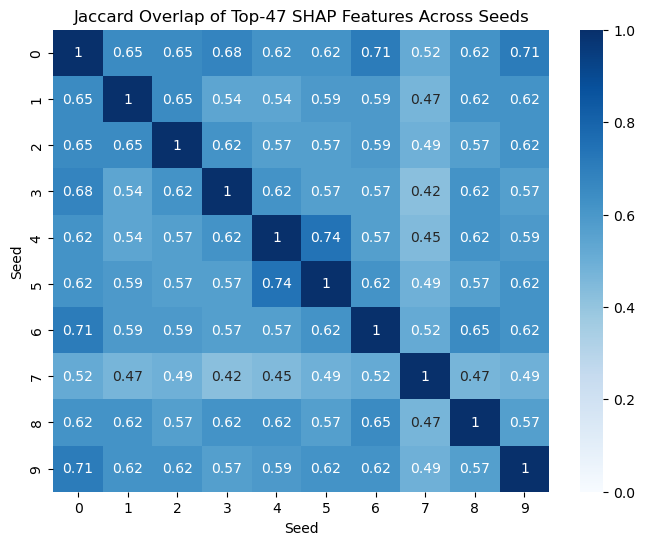

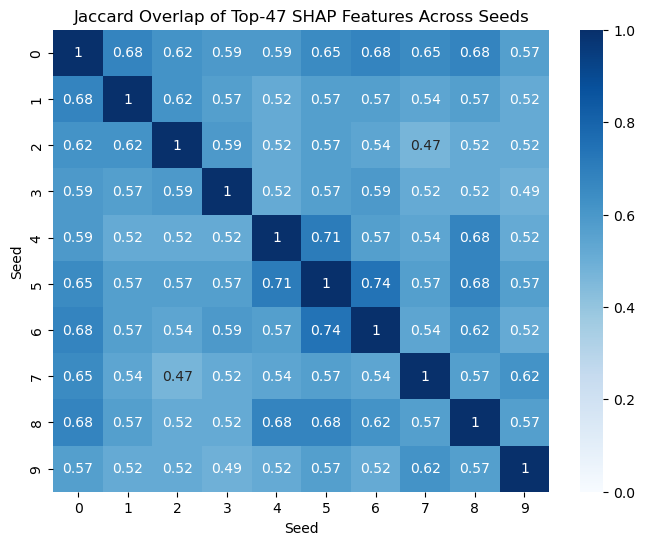

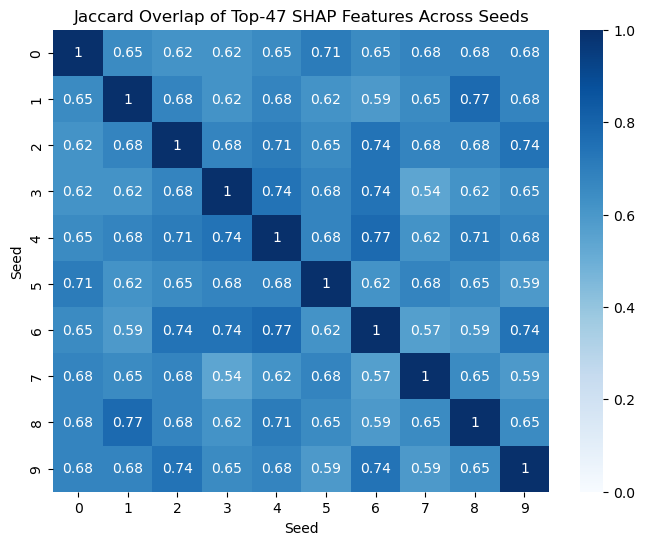

In [77]:
# SHAP Stability Heatmap (Seed × Feature Overlap)
# Pairwise Jaccard similarity between the top 30 SHAP features across 10 random seeds. 
# High similarity (0.65–0.80 range) indicates that the model repeatedly identifies a consistent subset of structural predictors.

plt.figure(figsize=(8,6))
sns.heatmap(jacc_mat_xgb, annot=True, cmap="Blues", vmin=0, vmax=1)
plt.title(f"Jaccard Overlap of Top-{top_n} SHAP Features Across Seeds")
plt.xlabel("Seed")
plt.ylabel("Seed")
plt.savefig(save_dir / "fig_feature_stability_xgb.png", dpi=300)

plt.figure(figsize=(8,6))
sns.heatmap(jacc_mat_lr, annot=True, cmap="Blues", vmin=0, vmax=1)
plt.title(f"Jaccard Overlap of Top-{top_n} SHAP Features Across Seeds")
plt.xlabel("Seed")
plt.ylabel("Seed")
plt.savefig(save_dir / "fig_feature_stability_lr.png", dpi=300)

plt.figure(figsize=(8,6))
sns.heatmap(jacc_mat_rf, annot=True, cmap="Blues", vmin=0, vmax=1)
plt.title(f"Jaccard Overlap of Top-{top_n} SHAP Features Across Seeds")
plt.xlabel("Seed")
plt.ylabel("Seed")
plt.savefig(save_dir / "fig_feature_stability_rf.png", dpi=300)

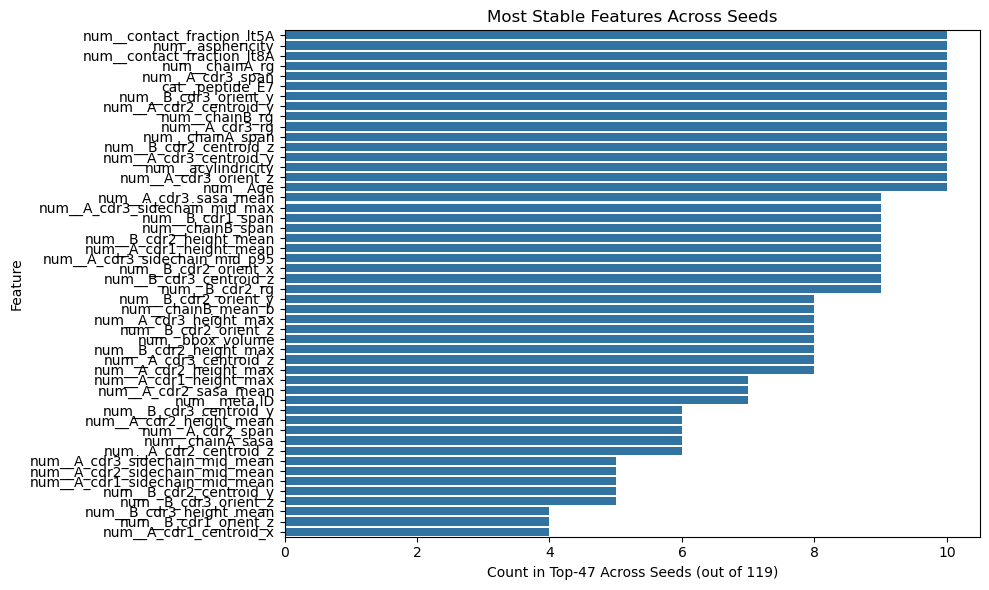

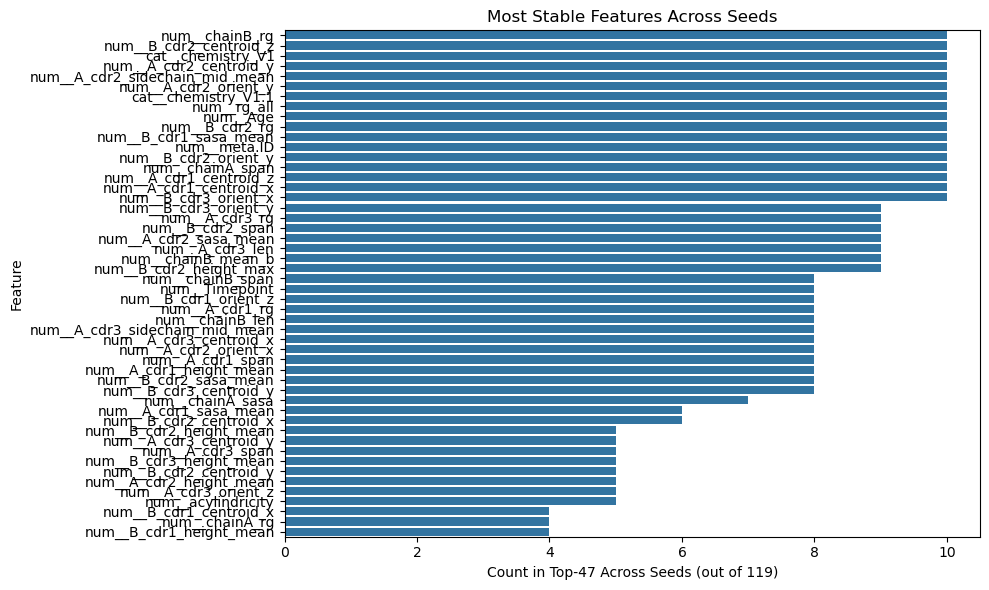

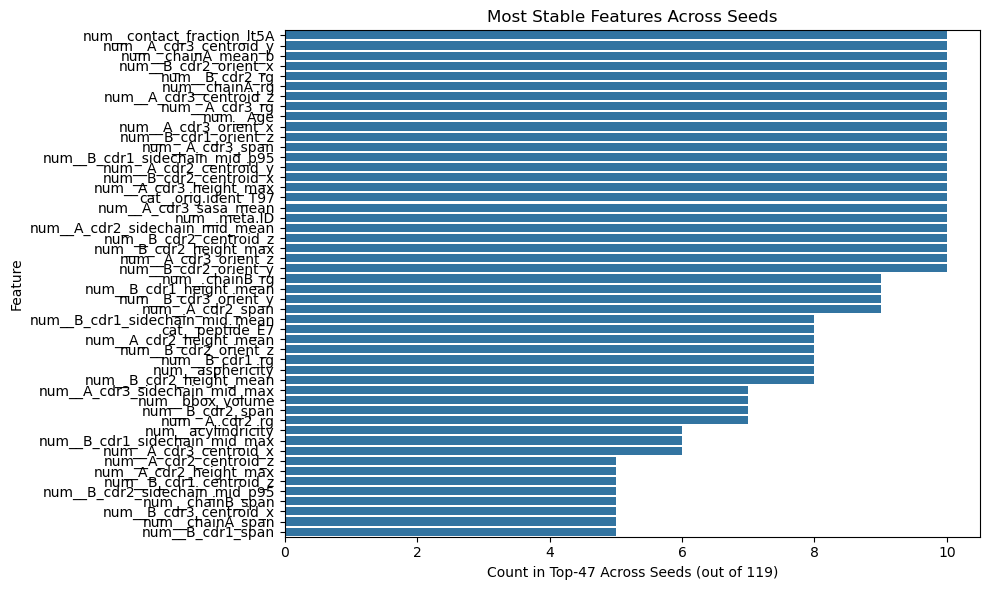

In [78]:
# Feature Consensus Barplot
# Show how often each feature appears in top-N across seeds.

from collections import Counter

# Flatten top-N lists
flat = []
for seed, feats in per_seed_topN_xgb.items():
    flat.extend(feats)

counts = Counter(flat)
freq_df = pd.DataFrame({
    "feature": list(counts.keys()),
    "freq": list(counts.values()),
}).sort_values("freq", ascending=False).head(50)

plt.figure(figsize=(10,6))
sns.barplot(y="feature", x="freq", data=freq_df)
plt.xlabel(f"Count in Top-{top_n} Across Seeds (out of {len(feature)})")
plt.ylabel("Feature")
plt.title("Most Stable Features Across Seeds")
plt.tight_layout()
plt.savefig(save_dir / "fig_feature_stability_counts_xgb.png", dpi=300)


# Flatten top-N lists
flat = []
for seed, feats in per_seed_topN_lr.items():
    flat.extend(feats)

counts = Counter(flat)
freq_df = pd.DataFrame({
    "feature": list(counts.keys()),
    "freq": list(counts.values()),
}).sort_values("freq", ascending=False).head(50)

plt.figure(figsize=(10,6))
sns.barplot(y="feature", x="freq", data=freq_df)
plt.xlabel(f"Count in Top-{top_n} Across Seeds (out of {len(feature)})")
plt.ylabel("Feature")
plt.title("Most Stable Features Across Seeds")
plt.tight_layout()
plt.savefig(save_dir / "fig_feature_stability_counts_lr.png", dpi=300)


# Flatten top-N lists
flat = []
for seed, feats in per_seed_topN_rf.items():
    flat.extend(feats)

counts = Counter(flat)
freq_df = pd.DataFrame({
    "feature": list(counts.keys()),
    "freq": list(counts.values()),
}).sort_values("freq", ascending=False).head(50)

plt.figure(figsize=(10,6))
sns.barplot(y="feature", x="freq", data=freq_df)
plt.xlabel(f"Count in Top-{top_n} Across Seeds (out of {len(feature)})")
plt.ylabel("Feature")
plt.title("Most Stable Features Across Seeds")
plt.tight_layout()
plt.savefig(save_dir / "fig_feature_stability_counts_rf.png", dpi=300)

In [71]:
# df_all is your merged struct+inter+res table, with label already added
ablation_df_xgb = run_feature_group_ablation(
    df_all=df2,
    feature_sets=feature_sets,
    base_cfg=cfg,
    label_col=label_col,
    model_name="xgboost",
)
ablation_df_xgb.to_csv(save_dir / "feature_group_ablation_xgb.csv",index=False,)


ablation_df_lr = run_feature_group_ablation(
    df_all=df2,
    feature_sets=feature_sets,
    base_cfg=cfg,
    label_col=label_col,
    model_name="logreg",
)
ablation_df_lr.to_csv(save_dir / "feature_group_ablation_lr.csv",index=False,)


ablation_df_rf = run_feature_group_ablation(
    df_all=df2,
    feature_sets=feature_sets,
    base_cfg=cfg,
    label_col=label_col,
    model_name="random_forest",
)
ablation_df_rf.to_csv(save_dir / "feature_group_ablation_rf.csv",index=False,)


[global] 1500 samples, 22 columns (features: 21)


[cdr] 1500 samples, 91 columns (features: 90)
[cdr_composition] 1500 samples, 115 columns (features: 114)
[cdr_comprehensive] 1500 samples, 235 columns (features: 234)
[global_cdr] 1500 samples, 112 columns (features: 111)
[global_cdr_composition] 1500 samples, 136 columns (features: 135)
[global_cdr_comprehensive] 1500 samples, 256 columns (features: 255)
[global_composition] 1500 samples, 46 columns (features: 45)
[global_comprehensive] 1500 samples, 166 columns (features: 165)
[interface] 1500 samples, 22 columns (features: 21)
[pairwise] 1500 samples, 221 columns (features: 220)
[interface_global] 1500 samples, 43 columns (features: 42)
[interface_cdr] 1500 samples, 112 columns (features: 111)
[interface_cdr_composition] 1500 samples, 136 columns (features: 135)
[interface_cdr_comprehensive] 1500 samples, 256 columns (features: 255)
[interface_global_cdr] 1500 samples, 133 columns (features: 132)
[interface_global_cdr_composition] 1500 samples, 157 columns (features: 156)
[interfac

/tmp/ipykernel_32151/3462588538.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha="right")
/tmp/ipykernel_32151/3462588538.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha="right")
/tmp/ipykernel_32151/3462588538.py:80: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha="right")


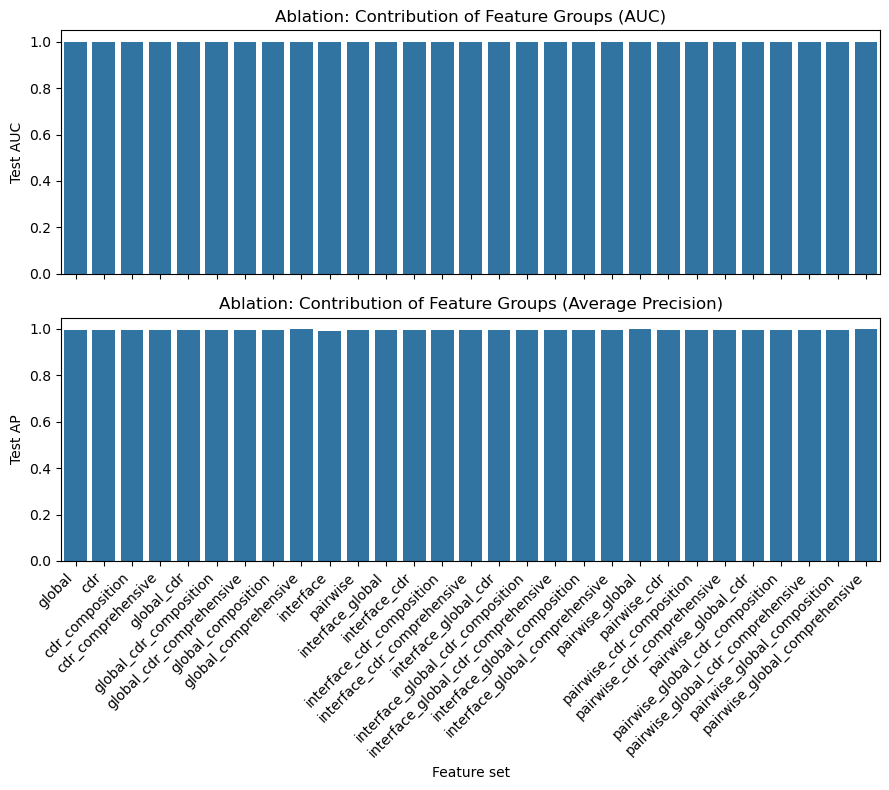

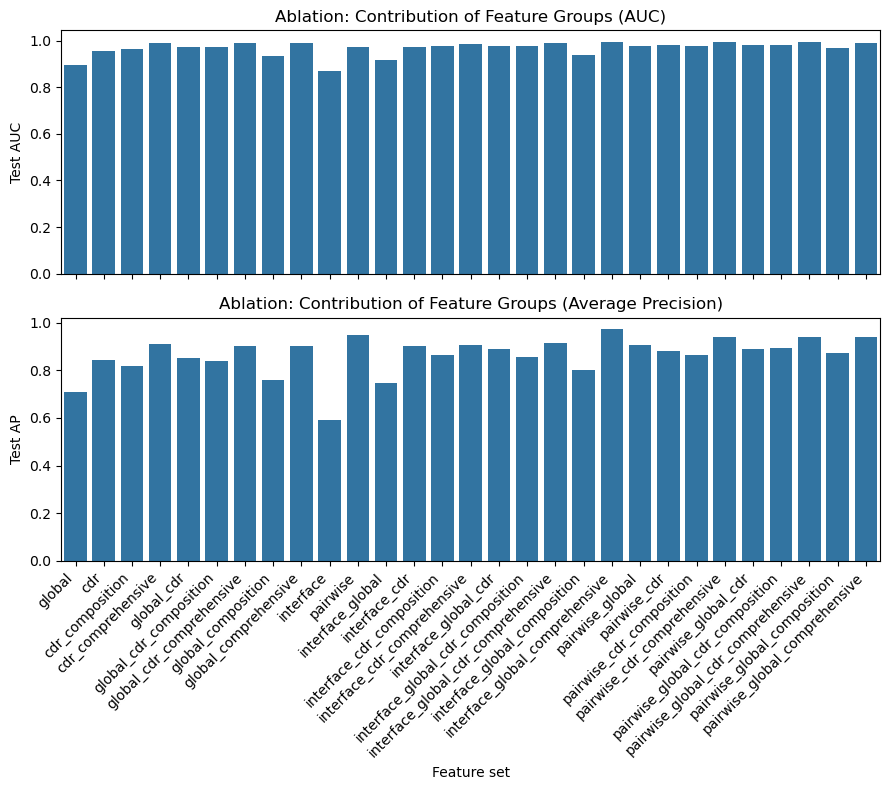

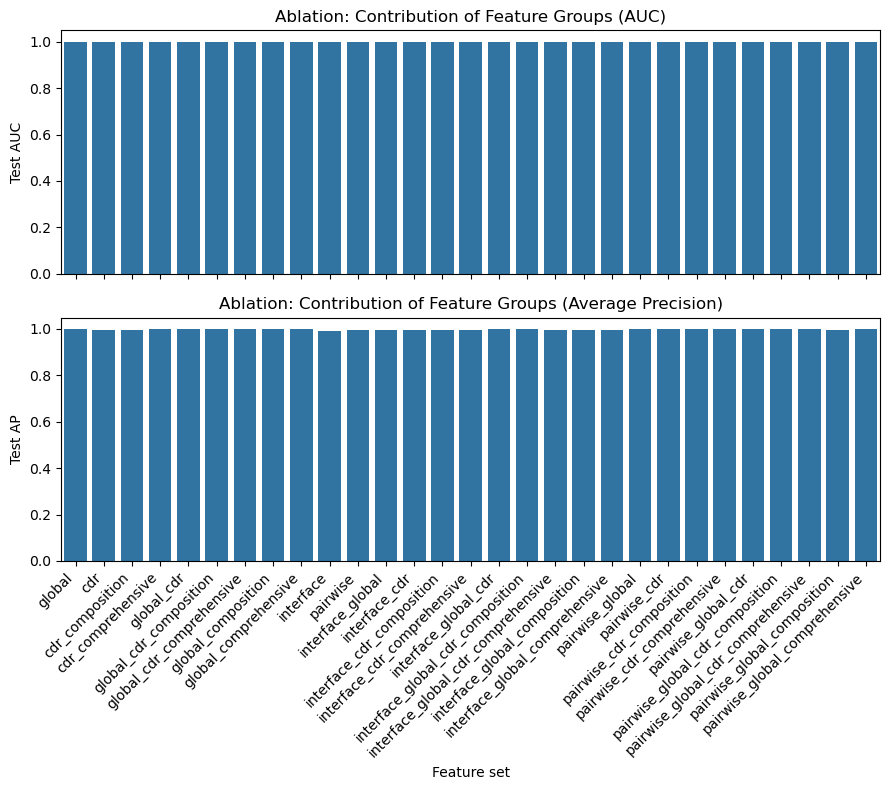

In [72]:
# Ablation Study: Feature Group Importance
# Show impact of removing each feature group on performance.
# Removing any of the three major structural groups 
# (global geometry, interface properties, residue-level energies) reduces AUC, 
# confirming that each provides complementary information.

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 8), sharex=True)
sns.barplot(
    data=ablation_df_xgb,
    x="feature_set",
    y="test_auc",
    ax=ax1
)
ax1.set_ylabel("Test AUC")
# ax1.set_ylim(0.9, 1.0)
ax1.set_title("Ablation: Contribution of Feature Groups (AUC)")

sns.barplot(
    data=ablation_df_xgb,
    x="feature_set",
    y="test_ap",
    ax=ax2
)
ax2.set_ylabel("Test AP")
# ax2.set_ylim(0.9, 1.0)
ax2.set_xlabel("Feature set")
ax2.set_title("Ablation: Contribution of Feature Groups (Average Precision)")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.savefig(save_dir / "fig_feature_group_ablation_xgb.png", dpi=300)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 8), sharex=True)
sns.barplot(
    data=ablation_df_lr,
    x="feature_set",
    y="test_auc",
    ax=ax1
)
ax1.set_ylabel("Test AUC")
# ax1.set_ylim(0.9, 1.0)
ax1.set_title("Ablation: Contribution of Feature Groups (AUC)")

sns.barplot(
    data=ablation_df_lr,
    x="feature_set",
    y="test_ap",
    ax=ax2
)
ax2.set_ylabel("Test AP")
# ax2.set_ylim(0.9, 1.0)
ax2.set_xlabel("Feature set")
ax2.set_title("Ablation: Contribution of Feature Groups (Average Precision)")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.savefig(save_dir / "fig_feature_group_ablation_lr.png", dpi=300)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 8), sharex=True)
sns.barplot(
    data=ablation_df_rf,
    x="feature_set",
    y="test_auc",
    ax=ax1
)
ax1.set_ylabel("Test AUC")
# ax1.set_ylim(0.9, 1.0)
ax1.set_title("Ablation: Contribution of Feature Groups (AUC)")

sns.barplot(
    data=ablation_df_rf,
    x="feature_set",
    y="test_ap",
    ax=ax2
)
ax2.set_ylabel("Test AP")
# ax2.set_ylim(0.9, 1.0)
ax2.set_xlabel("Feature set")
ax2.set_title("Ablation: Contribution of Feature Groups (Average Precision)")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.savefig(save_dir / "fig_feature_group_ablation_rf.png", dpi=300)


In [ ]:
# Main combined feature set: struct + inter + res
df_all = _merge_on_id(cfg, [df_meta, df_struct, df_inter, df_res])

family_col = "Nils.cdr3b_aa.patient_id.stimulation_0307"  # <-- replace with your actual metadata column

meta_path = Path(cfg["metadata_csv"])
if not meta_path.exists():
    raise FileNotFoundError(f"Metadata CSV not found: {meta_path}")

meta = pd.read_csv(meta_path, encoding=cfg.get("metadata_encoding", "utf-8"))
meta[id_col] = meta[id_col].astype(str).str.replace(".pdb", "", regex=False)

if family_col not in meta.columns:
    raise ValueError(f"family_column '{family_col}' not found in metadata.")
if label_col not in meta.columns:
    raise ValueError(f"label_column '{label_col}' not found in metadata.")

df_all_family = df_all.merge(meta[[id_col, family_col, label_col]], how="left", left_on=id_col, right_on=id_col)
df_all_family = df_all_family.drop(columns=[id_col])
df_all_family = df_all_family.loc[~df_all_family[label_col].isna()]

df_all_family[[family_col]] = df_all_family[[family_col]].fillna(value="unknown")

loo_df_xgb = leave_one_family_out(df_all_family, label_col, family_col, cfg, model_name="xgboost")
loo_df_xgb.to_csv(save_dir / "leave_one_protein_out_xgb.csv", index=False)

loo_df_lr = leave_one_family_out(df_all_family, label_col, family_col, cfg, model_name="logreg")
loo_df_lr.to_csv(save_dir / "leave_one_protein_out_lr.csv", index=False)

loo_df_rf = leave_one_family_out(df_all_family, label_col, family_col, cfg, model_name="random_forest")
loo_df_rf.to_csv(save_dir / "leave_one_protein_out_rf.csv", index=False)



KeyError: "None of [Index(['Nils.cdr3b_aa.patient_id.stimulation_0307'], dtype='object')] are in the [columns]"

/tmp/ipykernel_32151/2448765952.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha="right")
/tmp/ipykernel_32151/2448765952.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha="right")
/tmp/ipykernel_32151/2448765952.py:91: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha="right")


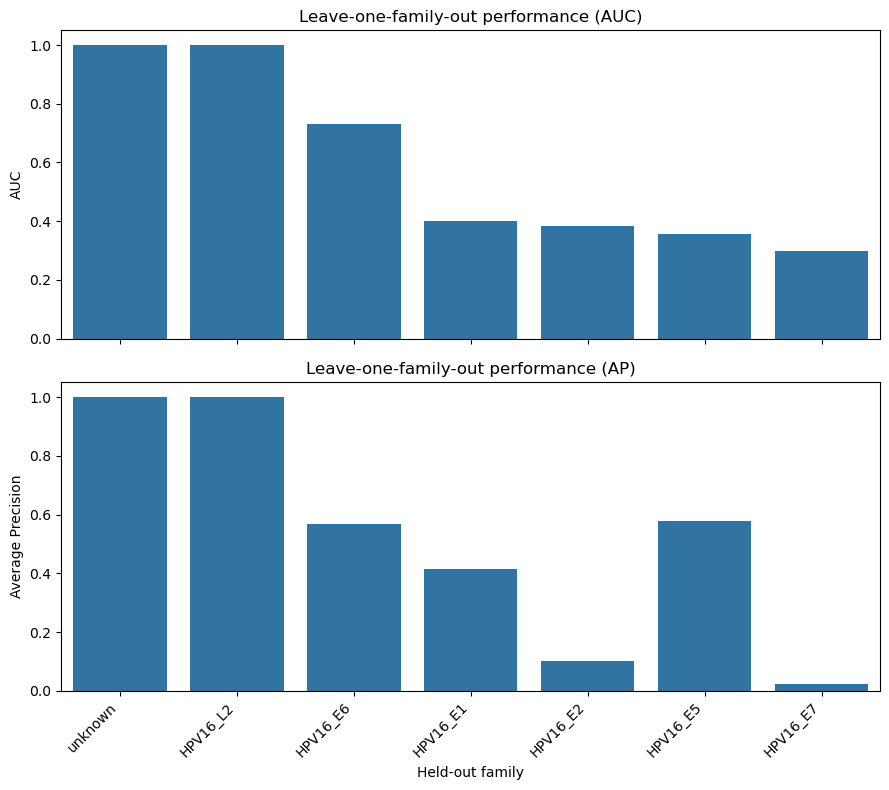

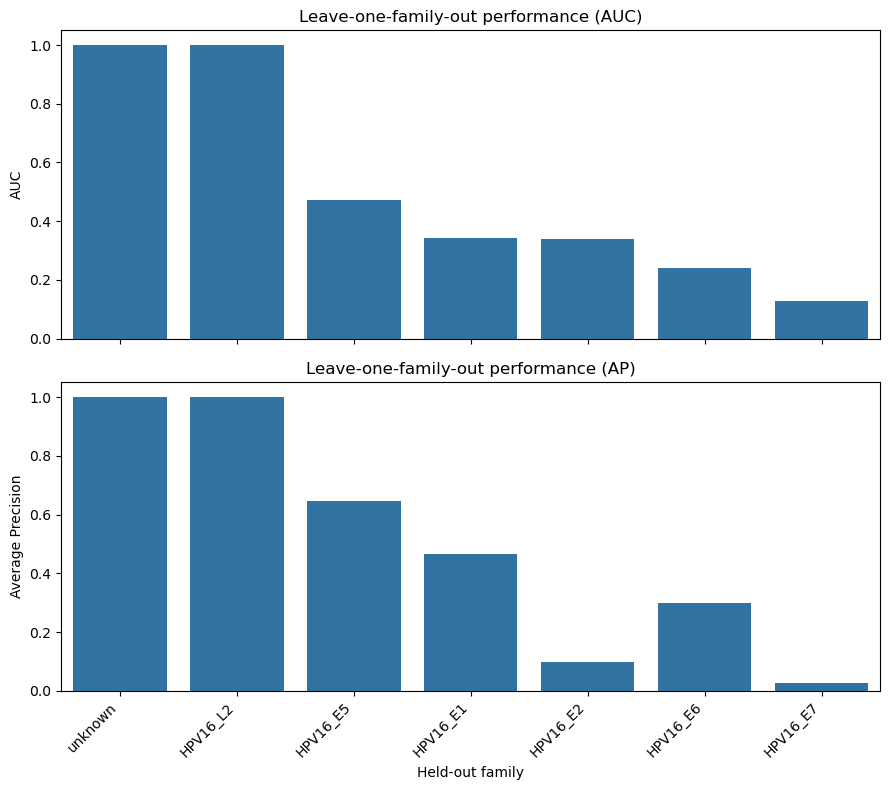

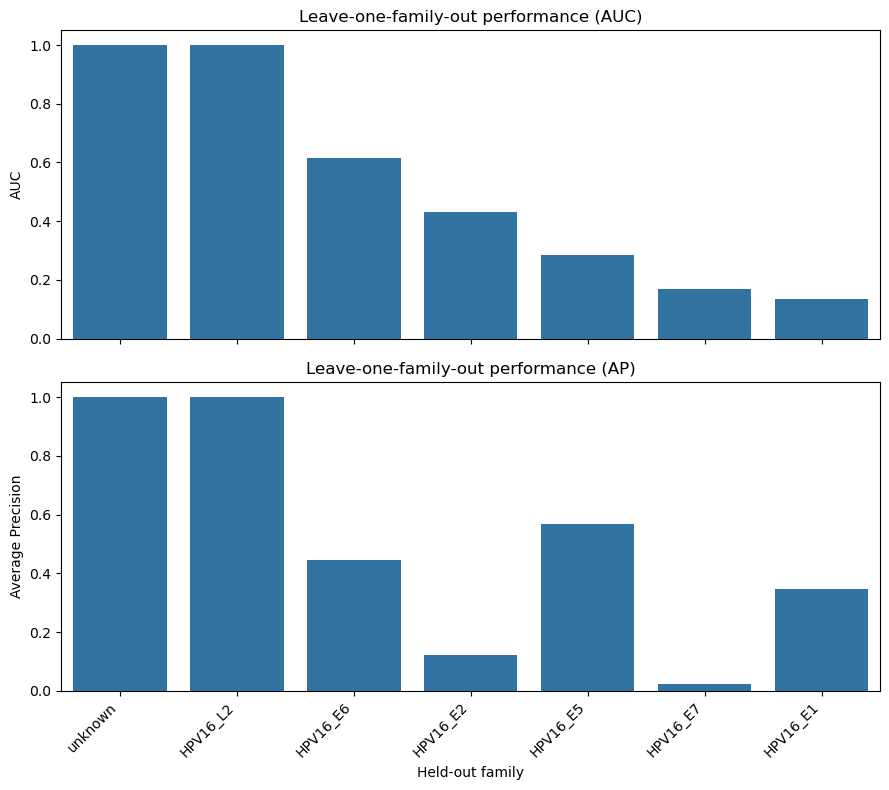

In [ ]:
loo_df_xgb = loo_df_xgb.sort_values("auc", ascending=False)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 8), sharex=True)

# AUC by family
sns.barplot(
    data=loo_df_xgb,
    x="protein",
    y="auc",
    ax=ax1,
)
ax1.set_ylabel("AUC")
ax1.set_title("Leave-one-protein-out performance (AUC)")

# AP by family
sns.barplot(
    data=loo_df_xgb,
    x="protein",
    y="ap",
    ax=ax2,
)
ax2.set_ylabel("Average Precision")
ax2.set_xlabel("Held-out protein")
ax2.set_title("Leave-one-protein-out performance (AP)")

# Rotate x labels
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.savefig(save_dir / "fig_leave_one_protein_out_xgb.png", dpi=300)


fig, ax = plt.subplots(figsize=(6, 5))
ax.scatter(loo_df_xgb["n_test"], loo_df_xgb["auc"])
for _, row in loo_df_xgb.iterrows():
    ax.text(row["n_test"], row["auc"], str(row["family"]), fontsize=8, alpha=0.7)

ax.set_xlabel("Number of TCRs in held-out family (n_test)")
ax.set_ylabel("AUC")
ax.set_title("Leave-one-family-out AUC vs family size")
plt.tight_layout()
plt.savefig(save_dir / "fig_leave_one_protein_out_size_xgb.png", dpi=300)




loo_df_lr = loo_df_lr.sort_values("auc", ascending=False)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 8), sharex=True)
# AUC by family
sns.barplot(
    data=loo_df_lr,
    x="protein",
    y="auc",
    ax=ax1,
)
ax1.set_ylabel("AUC")
ax1.set_title("Leave-one-protein-out performance (AUC)")

# AP by family
sns.barplot(
    data=loo_df_lr,
    x="protein",
    y="ap",
    ax=ax2,
)
ax2.set_ylabel("Average Precision")
ax2.set_xlabel("Held-out protein")
ax2.set_title("Leave-one-protein-out performance (AP)")

# Rotate x labels
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.savefig(save_dir / "fig_leave_one_protein_out_lr.png", dpi=300)

fig, ax = plt.subplots(figsize=(6, 5))
ax.scatter(loo_df_lr["n_test"], loo_df_lr["auc"])
for _, row in loo_df_lr.iterrows():
    ax.text(row["n_test"], row["auc"], str(row["family"]), fontsize=8, alpha=0.7)

ax.set_xlabel("Number of TCRs in held-out family (n_test)")
ax.set_ylabel("AUC")
ax.set_title("Leave-one-family-out AUC vs family size")
plt.tight_layout()
plt.savefig(save_dir / "fig_leave_one_protein_out_size_lr.png", dpi=300)




loo_df_rf = loo_df_rf.sort_values("auc", ascending=False)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 8), sharex=True)
# AUC by family
sns.barplot(
    data=loo_df_rf,
    x="protein",
    y="auc",
    ax=ax1,
)
ax1.set_ylabel("AUC")
ax1.set_title("Leave-one-protein-out performance (AUC)")

# AP by family
sns.barplot(
    data=loo_df_rf,
    x="protein",
    y="ap",
    ax=ax2,
)
ax2.set_ylabel("Average Precision")
ax2.set_xlabel("Held-out protein")
ax2.set_title("Leave-one-protein-out performance (AP)")

# Rotate x labels
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.savefig(save_dir / "fig_leave_one_protein_out_rf.png", dpi=300)


fig, ax = plt.subplots(figsize=(6, 5))
ax.scatter(loo_df_rf["n_test"], loo_df_rf["auc"])
for _, row in loo_df_rf.iterrows():
    ax.text(row["n_test"], row["auc"], str(row["family"]), fontsize=8, alpha=0.7)

ax.set_xlabel("Number of TCRs in held-out family (n_test)")
ax.set_ylabel("AUC")
ax.set_title("Leave-one-family-out AUC vs family size")
plt.tight_layout()
plt.savefig(save_dir / "fig_leave_one_protein_out_size_rf.png", dpi=300)


In [98]:
family_col = "orig.ident"

df_all_family = df_all.merge(meta[[id_col, label_col]], how="left", left_on=id_col, right_on=id_col)
df_all_family = df_all_family.drop(columns=[id_col])
df_all_family = df_all_family.loc[~df_all_family[label_col].isna()]

df_all_family[[family_col]] = df_all_family[[family_col]].fillna(value="unknown")

loo_df_xgb = leave_one_family_out(df_all_family, label_col, family_col, cfg, model_name="xgboost")
loo_df_xgb.to_csv(save_dir / "leave_one_sample_out_xgb.csv", index=False)

loo_df_lr = leave_one_family_out(df_all_family, label_col, family_col, cfg, model_name="logreg")
loo_df_lr.to_csv(save_dir / "leave_one_sample_out_lr.csv", index=False)

loo_df = leave_one_family_out(df_all_family, label_col, family_col, cfg, model_name="random_forest")
loo_df.to_csv(save_dir / "leave_one_sample_out_rf.csv", index=False)

Family T100: AUC=1.000, AP=1.000, n_test=22
Family T102: AUC=1.000, AP=1.000, n_test=5
Skipping family T103: only one class present in test.
Family T105: AUC=0.999, AP=0.983, n_test=395
Family T106: AUC=1.000, AP=1.000, n_test=2
Family T107: AUC=1.000, AP=1.000, n_test=3
Family T108: AUC=0.875, AP=0.450, n_test=18
Family T12: AUC=0.416, AP=0.572, n_test=30
Skipping family T13: only one class present in test.
Skipping family T16: only one class present in test.
Skipping family T21: only one class present in test.
Skipping family T22: only one class present in test.
Skipping family T30: only one class present in test.
Family T31: AUC=0.998, AP=0.998, n_test=128
Skipping family T36: only one class present in test.
Skipping family T38: only one class present in test.
Family T39: AUC=0.999, AP=0.999, n_test=100
Skipping family T41: only one class present in test.
Skipping family T50: only one class present in test.
Family T52: AUC=1.000, AP=1.000, n_test=8
Family T55: AUC=0.875, AP=0.833, n

/tmp/ipykernel_32151/1397805711.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha="right")
/tmp/ipykernel_32151/1397805711.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha="right")
/tmp/ipykernel_32151/1397805711.py:116: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha="right")


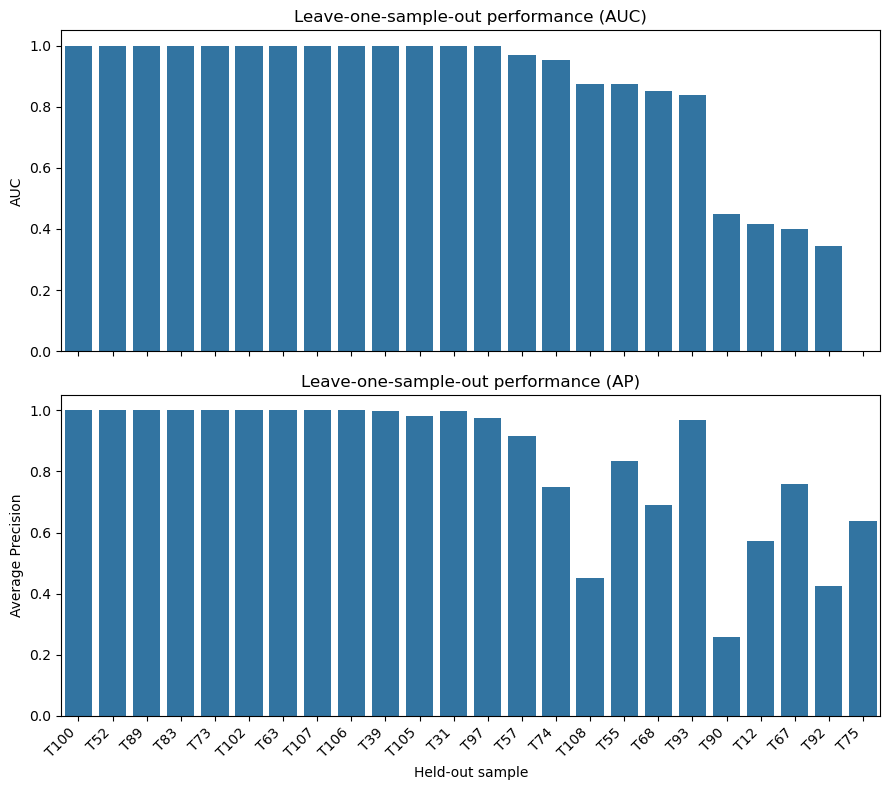

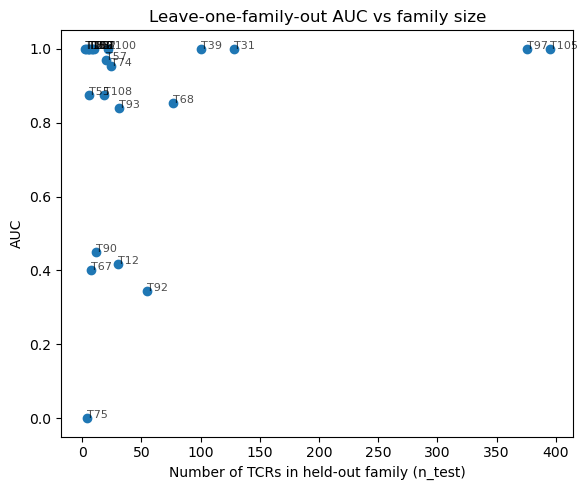

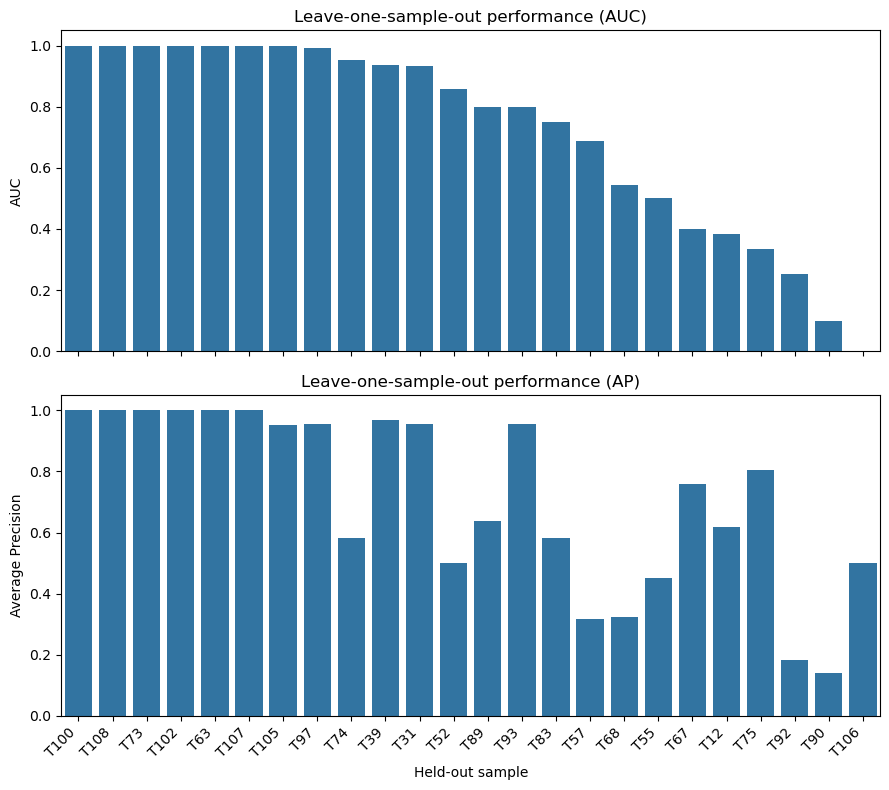

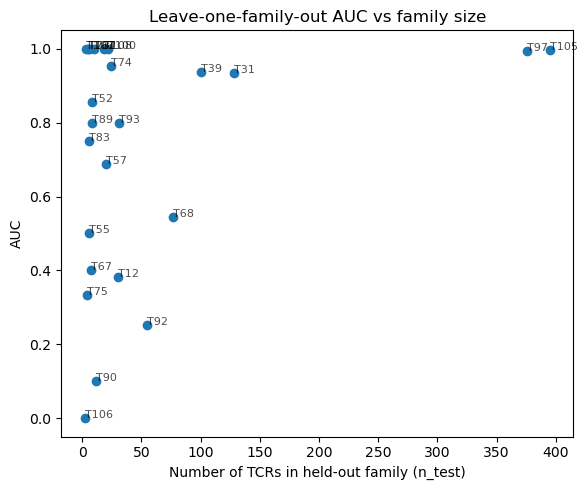

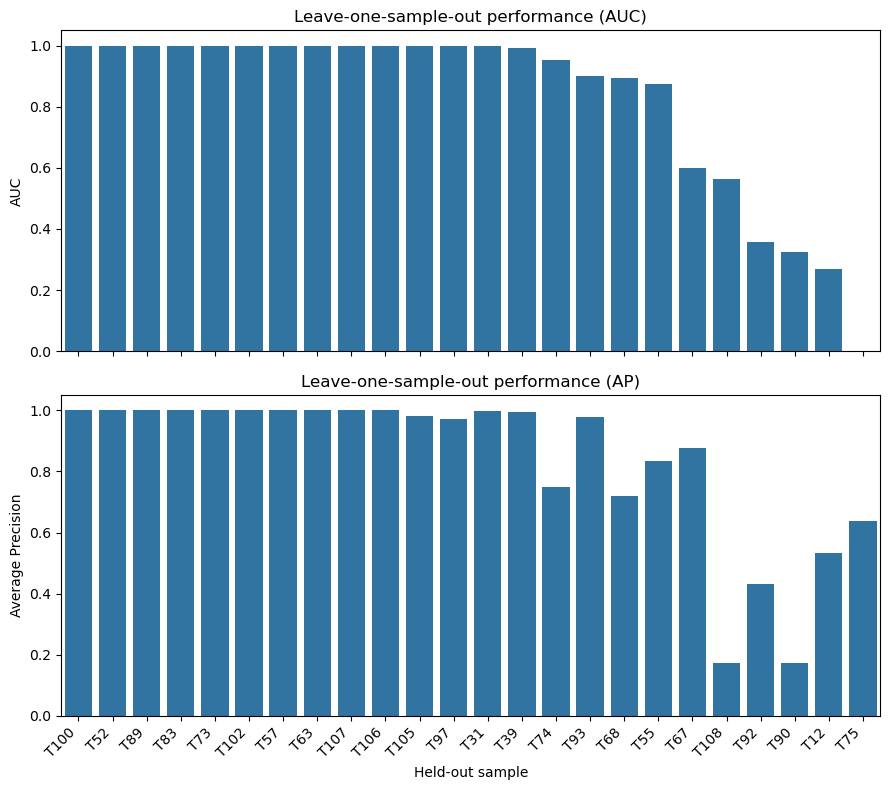

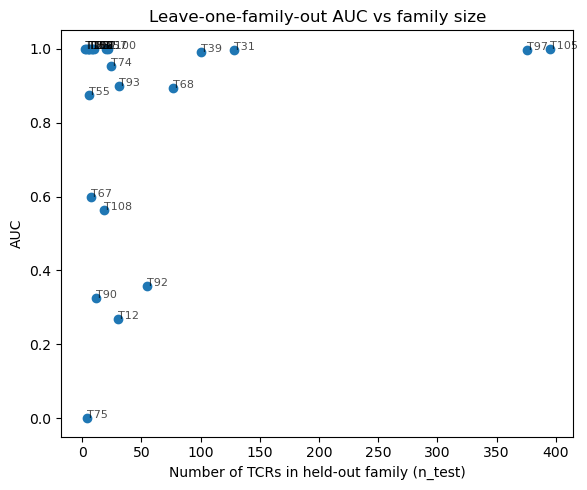

In [ ]:
loo_df_xgb_sorted = loo_df_xgb.sort_values("auc", ascending=False)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 8), sharex=True)

# AUC by family
sns.barplot(
    data=loo_df_xgb_sorted,
    x="family",
    y="auc",
    ax=ax1,
)
ax1.set_ylabel("AUC")
ax1.set_title("Leave-one-sample-out performance (AUC)")
    
# AP by family
sns.barplot(
    data=loo_df_xgb_sorted,
    x="family",
    y="ap",
    ax=ax2,
)
ax2.set_ylabel("Average Precision")
ax2.set_xlabel("Held-out sample")
ax2.set_title("Leave-one-sample-out performance (AP)")
    
# Rotate x labels
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.savefig(save_dir / "fig_leave_one_sample_out_xgb.png", dpi=300)

fig, ax = plt.subplots(figsize=(6, 5))
ax.scatter(loo_df_xgb["n_test"], loo_df_xgb["auc"])
for _, row in loo_df_xgb.iterrows():
    ax.text(row["n_test"], row["auc"], str(row["family"]), fontsize=8, alpha=0.7)

ax.set_xlabel("Number of TCRs in held-out family (n_test)")
ax.set_ylabel("AUC")
ax.set_title("Leave-one-family-out AUC vs family size")
plt.tight_layout()
plt.savefig(save_dir / "fig_leave_one_sample_out_size_xgb.png", dpi=300)



loo_df_lr_sorted = loo_df_lr.sort_values("auc", ascending=False)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 8), sharex=True)

# AUC by family
sns.barplot(
    data=loo_df_lr_sorted,
    x="family",
    y="auc",
    ax=ax1,
)
ax1.set_ylabel("AUC")
ax1.set_title("Leave-one-sample-out performance (AUC)")
    
# AP by family
sns.barplot(
    data=loo_df_lr_sorted,
    x="family",
    y="ap",
    ax=ax2,
)
ax2.set_ylabel("Average Precision")
ax2.set_xlabel("Held-out sample")
ax2.set_title("Leave-one-sample-out performance (AP)")
    
# Rotate x labels
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.savefig(save_dir / "fig_leave_one_sample_out_lr.png", dpi=300)

fig, ax = plt.subplots(figsize=(6, 5))

ax.scatter(loo_df_lr_sorted["n_test"], loo_df_lr_sorted["auc"])
for _, row in loo_df_lr_sorted.iterrows():
    ax.text(row["n_test"], row["auc"], str(row["family"]), fontsize=8, alpha=0.7)

ax.set_xlabel("Number of TCRs in held-out family (n_test)")
ax.set_ylabel("AUC")
ax.set_title("Leave-one-family-out AUC vs family size")
plt.tight_layout()
plt.savefig(save_dir / "fig_leave_one_sample_out_size_lr.png", dpi=300)





loo_df_sorted = loo_df.sort_values("auc", ascending=False)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 8), sharex=True)

# AUC by family
sns.barplot(
    data=loo_df_sorted,
    x="family",
    y="auc",
    ax=ax1,
)
ax1.set_ylabel("AUC")
ax1.set_title("Leave-one-sample-out performance (AUC)")
    
# AP by family
sns.barplot(
    data=loo_df_sorted,
    x="family",
    y="ap",
    ax=ax2,
)
ax2.set_ylabel("Average Precision")
ax2.set_xlabel("Held-out sample")
ax2.set_title("Leave-one-sample-out performance (AP)")
    
# Rotate x labels
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.savefig(save_dir / "fig_leave_one_sample_out_rf.png", dpi=300)

fig, ax = plt.subplots(figsize=(6, 5))

ax.scatter(loo_df_sorted["n_test"], loo_df_sorted["auc"])
for _, row in loo_df_sorted.iterrows():
    ax.text(row["n_test"], row["auc"], str(row["family"]), fontsize=8, alpha=0.7)

ax.set_xlabel("Number of TCRs in held-out family (n_test)")
ax.set_ylabel("AUC")
ax.set_title("Leave-one-family-out AUC vs family size")
plt.tight_layout()
plt.savefig(save_dir / "fig_leave_one_sample_out_size_rf.png", dpi=300)


In [99]:
family_col = "meta.ID"

df_all_family = df_all.merge(meta[[id_col, label_col]], how="left", left_on=id_col, right_on=id_col)
df_all_family = df_all_family.drop(columns=[id_col])
df_all_family = df_all_family.loc[~df_all_family[label_col].isna()]

df_all_family[[family_col]] = df_all_family[[family_col]].fillna(value="unknown")

loo_df_xgb = leave_one_family_out(df_all_family, label_col, family_col, cfg, model_name="xgboost")
loo_df_xgb.to_csv(save_dir / "leave_one_patient_out_xgb.csv", index=False)

loo_df_lr = leave_one_family_out(df_all_family, label_col, family_col, cfg, model_name="logreg")
loo_df_lr.to_csv(save_dir / "leave_one_patient_out_lr.csv", index=False)

loo_df = leave_one_family_out(df_all_family, label_col, family_col, cfg, model_name="random_forest")
loo_df.to_csv(save_dir / "leave_one_patient_out_rf.csv", index=False)

Family 32: AUC=0.967, AP=0.925, n_test=30
Family 34: AUC=0.286, AP=0.163, n_test=17
Skipping family 33: only one class present in test.
Family 38: AUC=0.704, AP=0.074, n_test=771
Family 37: AUC=0.000, AP=0.755, n_test=8
Family 36: AUC=1.000, AP=1.000, n_test=3
Family 39: AUC=0.875, AP=0.450, n_test=18
Family 2: AUC=0.416, AP=0.572, n_test=30
Skipping family 6: only one class present in test.
Skipping family 4: only one class present in test.
Skipping family 7: only one class present in test.
Skipping family 9: only one class present in test.
Family 10: AUC=0.188, AP=0.325, n_test=228
Skipping family 11: only one class present in test.
Skipping family 12: only one class present in test.
Family 15: AUC=0.938, AP=0.950, n_test=8
Family 16: AUC=0.217, AP=0.137, n_test=28
Family 18: AUC=0.933, AP=0.996, n_test=16
Skipping family 19: only one class present in test.
Family 21: AUC=1.000, AP=1.000, n_test=16
Family 22: AUC=0.458, AP=0.747, n_test=11
Family 23: AUC=0.687, AP=0.598, n_test=101
S

/tmp/ipykernel_32151/206815255.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha="right")
/tmp/ipykernel_32151/206815255.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha="right")
/tmp/ipykernel_32151/206815255.py:115: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha="right")


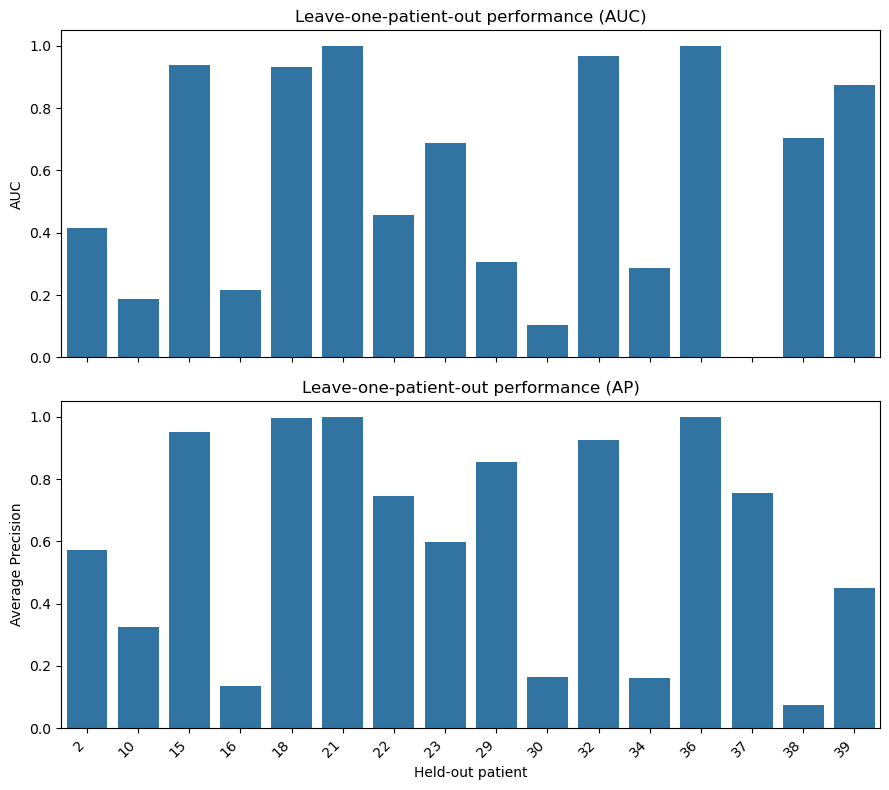

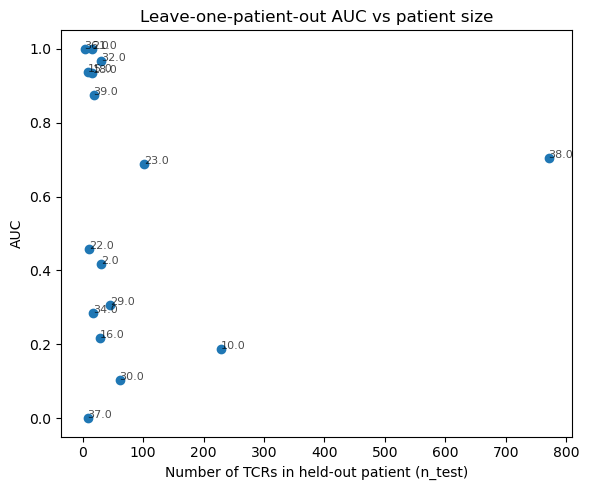

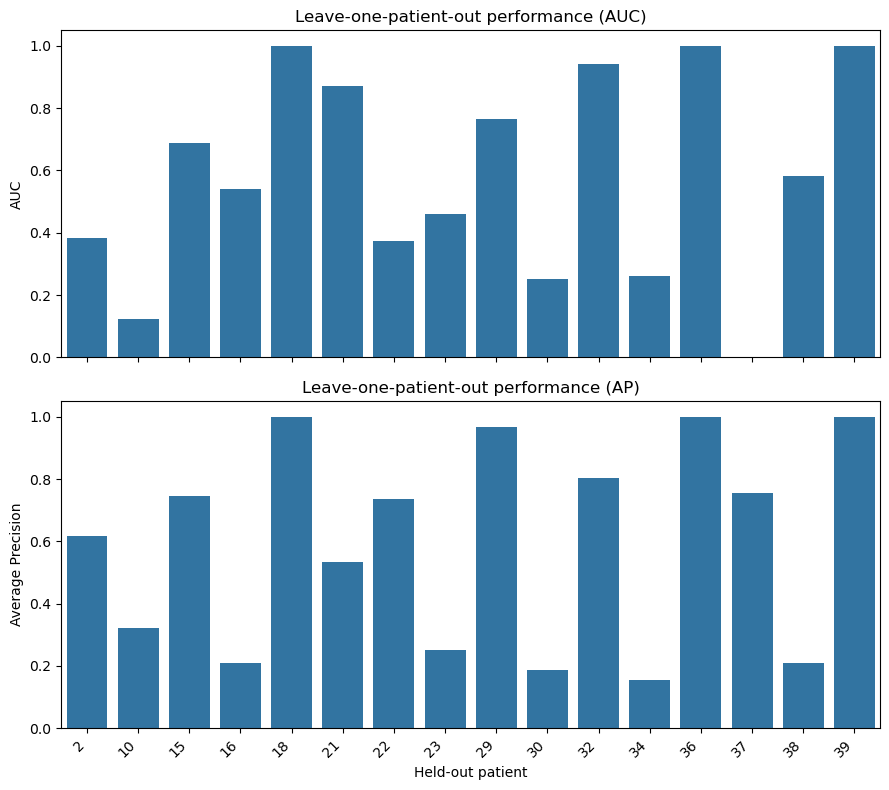

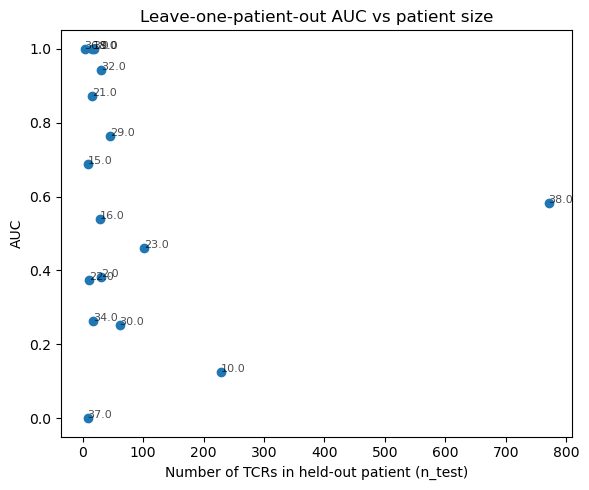

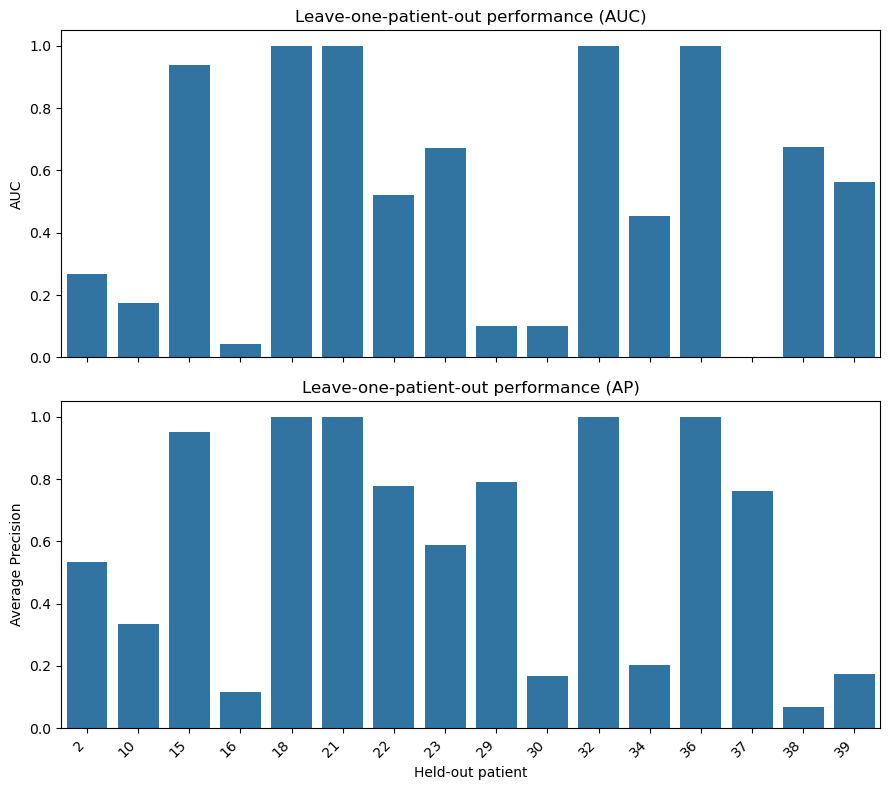

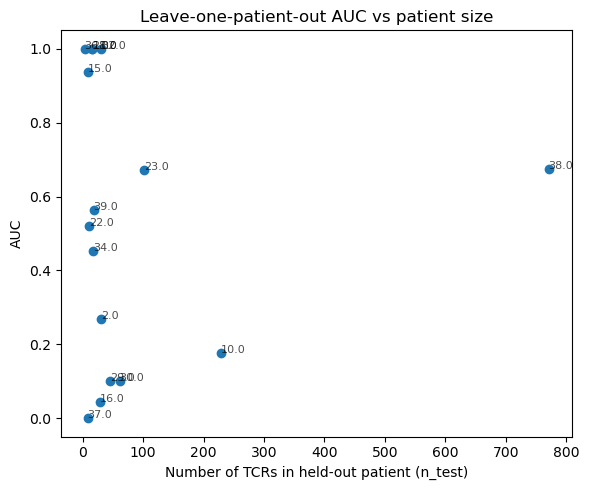

In [100]:
loo_df_xgb_sorted = loo_df_xgb.sort_values("auc", ascending=False)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 8), sharex=True)

# AUC by family
sns.barplot(
    data=loo_df_xgb_sorted,
    x="family",
    y="auc",
    ax=ax1,
)
ax1.set_ylabel("AUC")
ax1.set_title("Leave-one-patient-out performance (AUC)")
    
# AP by family
sns.barplot(
    data=loo_df_xgb_sorted,
    x="family",
    y="ap",
    ax=ax2,
)
ax2.set_ylabel("Average Precision")
ax2.set_xlabel("Held-out patient")
ax2.set_title("Leave-one-patient-out performance (AP)")
    
# Rotate x labels
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.savefig(save_dir / "fig_leave_one_patient_out_xgb.png", dpi=300)

fig, ax = plt.subplots(figsize=(6, 5))
ax.scatter(loo_df_xgb["n_test"], loo_df_xgb["auc"])
for _, row in loo_df_xgb.iterrows():
    ax.text(row["n_test"], row["auc"], str(row["family"]), fontsize=8, alpha=0.7)

ax.set_xlabel("Number of TCRs in held-out patient (n_test)")
ax.set_ylabel("AUC")
ax.set_title("Leave-one-patient-out AUC vs patient size")
plt.tight_layout()
plt.savefig(save_dir / "fig_leave_one_patient_out_size_xgb.png", dpi=300)



loo_df_lr_sorted = loo_df_lr.sort_values("auc", ascending=False)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 8), sharex=True)

# AUC by family
sns.barplot(
    data=loo_df_lr_sorted,
    x="family",
    y="auc",
    ax=ax1,
)
ax1.set_ylabel("AUC")
ax1.set_title("Leave-one-patient-out performance (AUC)")
    
# AP by family
sns.barplot(
    data=loo_df_lr_sorted,
    x="family",
    y="ap",
    ax=ax2,
)
ax2.set_ylabel("Average Precision")
ax2.set_xlabel("Held-out patient")
ax2.set_title("Leave-one-patient-out performance (AP)")
    
# Rotate x labels
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.savefig(save_dir / "fig_leave_one_patient_out_lr.png", dpi=300)

fig, ax = plt.subplots(figsize=(6, 5))

ax.scatter(loo_df_lr_sorted["n_test"], loo_df_lr_sorted["auc"])
for _, row in loo_df_lr_sorted.iterrows():
    ax.text(row["n_test"], row["auc"], str(row["family"]), fontsize=8, alpha=0.7)

ax.set_xlabel("Number of TCRs in held-out patient (n_test)")
ax.set_ylabel("AUC")
ax.set_title("Leave-one-patient-out AUC vs patient size")
plt.tight_layout()
plt.savefig(save_dir / "fig_leave_one_patient_out_size_lr.png", dpi=300)





loo_df_sorted = loo_df.sort_values("auc", ascending=False)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 8), sharex=True)

# AUC by family
sns.barplot(
    data=loo_df_sorted,
    x="family",
    y="auc",
    ax=ax1,
)
ax1.set_ylabel("AUC")
ax1.set_title("Leave-one-patient-out performance (AUC)")
    
# AP by family
sns.barplot(
    data=loo_df_sorted,
    x="family",
    y="ap",
    ax=ax2,
)
ax2.set_ylabel("Average Precision")
ax2.set_xlabel("Held-out patient")
ax2.set_title("Leave-one-patient-out performance (AP)")
    
# Rotate x labels
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.savefig(save_dir / "fig_leave_one_patient_out_rf.png", dpi=300)

fig, ax = plt.subplots(figsize=(6, 5))

ax.scatter(loo_df_sorted["n_test"], loo_df_sorted["auc"])
for _, row in loo_df_sorted.iterrows():
    ax.text(row["n_test"], row["auc"], str(row["family"]), fontsize=8, alpha=0.7)

ax.set_xlabel("Number of TCRs in held-out patient (n_test)")
ax.set_ylabel("AUC")
ax.set_title("Leave-one-patient-out AUC vs patient size")
plt.tight_layout()
plt.savefig(save_dir / "fig_leave_one_patient_out_size_rf.png", dpi=300)


In [ ]:
cols = ['WholeVdj_B-cdr3','WholeVdj_TRBV','WholeVdj_TRBJ','WholeVdj_TRBD','WholeVdj_A-cdr3','WholeVdj_TRAV','WholeVdj_TRAJ']
dat[cols] = dat[cols].apply(lambda col: col.astype(str).str.split(';').str[0].replace('TRB','TCRB').replace('TRA','TCRA'))
dat.rename(columns={'paired_idx':'count','WholeVdj_B-cdr3':'trb_aa','WholeVdj_TRBV':'trbv','WholeVdj_TRBJ':'trbj','WholeVdj_TRBD':'trbd','WholeVdj_A-cdr3':'tra_aa','WholeVdj_TRAV':'trav','WholeVdj_TRAJ':'traj'}, inplace=True)

df0 = dat[dat['HPV_validated.fest.GES']=='no'][['count','trb_aa','trbv','trbj','trbd','tra_aa','trav','traj']]
df1 = dat[dat['HPV_validated.fest.GES']=='yes'][['count','trb_aa','trbv','trbj','trbd','tra_aa','trav','traj']]

In [ ]:
df = pd.read_csv('/rsrch3/scratch/genomic_med/kkim14/data/maura_hnncc/meta_label_sep4_hpv_specific_with_wholevdj.csv')
df_1 = df[df['HPV_validated.fest.GES']=='yes'][['tcr_id','WholeVdj_B-cdr3','WholeVdj_TRBV','WholeVdj_TRBJ']]
df_1_count = df_1.groupby(['WholeVdj_B-cdr3','WholeVdj_TRBV','WholeVdj_TRBJ']).size().reset_index(name='Count')

df_0 = df[df['HPV_validated.fest.GES']=='no'][['tcr_id','WholeVdj_B-cdr3','WholeVdj_TRBV','WholeVdj_TRBJ']]
df_0_count = df_0.groupby(['WholeVdj_B-cdr3','WholeVdj_TRBV','WholeVdj_TRBJ']).size().reset_index(name='Count')
df_0_count.to_csv('/rsrch3/scratch/genomic_med/kkim14/data/maura_hnncc/specific/meta_label_specific_no_count.tsv', sep='\t', index=False)
df_1_count.to_csv('/rsrch3/scratch/genomic_med/kkim14/data/maura_hnncc/specific/meta_label_specific_yes_count.tsv', sep='\t', index=False)

from DeepTCR.DeepTCR import DeepTCR_SS
DTCR_SS = DeepTCR_SS('/rsrch3/scratch/genomic_med/kkim14/data/maura_hnncc/DeepTCR')
DTCR_SS.Get_Data(directory='/rsrch3/scratch/genomic_med/kkim14/data/maura_hnncc/specific',Load_Prev_Data=False,aggregate_by_aa=True,aa_column_beta=0,count_column=3,v_beta_column=1,j_beta_column=2)
DTCR_SS.Get_Train_Valid_Test(test_size=0.2)


In [ ]:
import pandas as pd
from pathlib import Path
path = Path('/rsrch3/scratch/genomic_med/kkim14/data/maura_hnncc/')
df = pd.read_csv(path /'meta_label_sep4_hpv_specific_with_wholevdj.csv')

df_0 = df[df['HPV_validated.fest.GES']=='no'][['tcr_id','WholeVdj_B-cdr3','WholeVdj_TRBV', 'WholeVdj_TRBJ', 'WholeVdj_TRBD', 'WholeVdj_A-cdr3','WholeVdj_TRAV', 'WholeVdj_TRAJ',]]
df_1 = df[df['HPV_validated.fest.GES']=='yes'][['tcr_id','WholeVdj_B-cdr3','WholeVdj_TRBV','WholeVdj_TRBJ', 'WholeVdj_TRBD', 'WholeVdj_A-cdr3','WholeVdj_TRAV', 'WholeVdj_TRAJ',]]
df_0['WholeVdj_TRBV'] = [x.split(';')[0].replace('TRB','TCRB') for x in df_0['WholeVdj_TRBV']]
df_0['WholeVdj_TRBJ'] = [x.split(';')[0].replace('TRB','TCRB') for x in df_0['WholeVdj_TRBJ']]
df_1['WholeVdj_TRBV'] = [x.split(';')[0].replace('TRB','TCRB') for x in df_1['WholeVdj_TRBV']]
df_1['WholeVdj_TRBJ'] = [x.split(';')[0].replace('TRB','TCRB') for x in df_1['WholeVdj_TRBJ']]
df_0['WholeVdj_TRBD'] = [x.split(';')[0].replace('TRB','TCRB') for x in df_0['WholeVdj_TRBD']]
df_1['WholeVdj_TRBD'] = [x.split(';')[0].replace('TRB','TCRB') for x in df_1['WholeVdj_TRBD']]
df_0['WholeVdj_TRAV'] = [x.split(';')[0].replace('TRA','TCRA') for x in df_0['WholeVdj_TRAV']]
df_0['WholeVdj_TRAJ'] = [x.split(';')[0].replace('TRA','TCRA') for x in df_0['WholeVdj_TRAJ']]
df_1['WholeVdj_TRAV'] = [x.split(';')[0].replace('TRA','TCRA') for x in df_1['WholeVdj_TRAV']]
df_1['WholeVdj_TRAJ'] = [x.split(';')[0].replace('TRA','TCRA') for x in df_1['WholeVdj_TRAJ']]

df_0['WholeVdj_B-cdr3'] = [x.split(';')[0] for x in df_0['WholeVdj_B-cdr3']]
df_0['WholeVdj_A-cdr3'] = [x.split(';')[0] for x in df_0['WholeVdj_A-cdr3']]
df_1['WholeVdj_B-cdr3'] = [x.split(';')[0] for x in df_1['WholeVdj_B-cdr3']]
df_1['WholeVdj_A-cdr3'] = [x.split(';')[0] for x in df_1['WholeVdj_A-cdr3']]

df_1_count = df_1.groupby(['WholeVdj_B-cdr3','WholeVdj_TRBV','WholeVdj_TRBJ','WholeVdj_TRBD','WholeVdj_A-cdr3','WholeVdj_TRAV','WholeVdj_TRAJ']).size().reset_index(name='Count')
df_0_count = df_0.groupby(['WholeVdj_B-cdr3','WholeVdj_TRBV','WholeVdj_TRBJ','WholeVdj_TRBD','WholeVdj_A-cdr3','WholeVdj_TRAV','WholeVdj_TRAJ']).size().reset_index(name='Count')

df_0_count.to_csv(path / 'specific/no/no.tsv', sep='\t', index=False)
df_1_count.to_csv(path / 'specific/yes/yes.tsv', sep='\t', index=False)



 

from DeepTCR.DeepTCR import DeepTCR_SS
ss = DeepTCR_SS('/rsrch3/scratch/genomic_med/kkim14/data/maura_hnncc/DeepTCR_SS')
ss.Get_Data(directory='/rsrch3/scratch/genomic_med/kkim14/data/maura_hnncc/specific',
                 Load_Prev_Data=False,aggregate_by_aa=False,
                 aa_column_beta=0,v_beta_column=1,j_beta_column=2,d_beta_column=3, aa_column_alpha=4, v_alpha_column=5, j_alpha_column=6, count_column=7
                 )
ss.sample_id

ss.K_Folds_CrossVal(folds=5)
ss.AUC_Curve()


y_test = ss.test_pred.__dict__['test'].y_test
y_pred = ss.test_pred.__dict__['test'].y_pred
for ii, class_name in enumerate(ss.lb.classes_,0):
    score = average_precision_score(y_test[:,ii], y_pred[:,ii])
    print(score)

DTCR_SS.Monte_Carlo_CrossVal(test_size=0.2,folds=20)
DTCR_SS.AUC_Curve()

In [170]:
16+45

61